### Funciones utilizadas para revisar resultados y analisis

Imports necesarios

In [2]:

from datetime import datetime

import os, time, pickle, csv, numpy as np, torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
from timm import create_model

from torch.utils.data import DataLoader, random_split
#Funciones generales para analizar resultados y métricas
from src.eval_utils import visualizar_curvas, evaluar_modelo, medir_inferencia

C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carga de datos y definicion de transformaciones

In [3]:
# =========================
# Configuración y SPLIT 80/15/5 reproducible
# =========================
import os, json, random, numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Semillas para reproducibilidad total (entrenamiento y evaluación)
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ruta al dataset 
data_path = 'TFM/food-101/food-101/images/'


# =========================
# TRANSFORMS
# =========================
# Transformaciones de entrenamiento (data augmentation + normalización)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # regularización adicional, BORRAR ALEATORIAMENTE 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transform de validación/test (sin aumentación; únicamente preprocesado)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



# =========================
# SPLIT ESTRATIFICADO 80/15/5 (persistente)
# =========================
split_file = "splits_food101_80_15_5_final.json"

# Dataset auxiliar SOLO para mapear rutas->clase e índices (no se usa para entrenar)
_full_indexer = datasets.ImageFolder(root=data_path, transform=transform_val)
class_names = _full_indexer.classes  # ← mantiene tu variable
total_size = len(_full_indexer)

if os.path.exists(split_file):
    # Cargar índices guardados (garantiza mismo split en cada ejecución)
    with open(split_file, "r") as f:
        idxs = json.load(f)
    train_idx = idxs["train"]
    val_idx   = idxs["val"]
    test_idx  = idxs["test"]
else:
    # Crear índices estratificados 80/15/5 y guardarlos
    labels_all = [lbl for _, lbl in _full_indexer.samples]
    all_idx = list(range(total_size))

    # 80% train vs 20% (val+test)
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        all_idx, labels_all, test_size=0.20, stratify=labels_all, random_state=seed
    )
    # Del 20% restante → 15% val y 5% test: 5/(15+5)=0.25
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.25, stratify=[labels_all[i] for i in temp_idx], random_state=seed
    )
    with open(split_file, "w") as f:
        json.dump({"train": train_idx, "val": val_idx, "test": test_idx}, f)

# =========================
# DATASETS (separados por transform para evitar efectos colaterales)
# =========================
# Nota: mantenemos el nombre 'full_dataset' como en tu código original, pero
# ahora lo usamos para exponer 'classes' y coherencia, no para los subsets.
full_dataset = datasets.ImageFolder(root=data_path, transform=transform_train)

# Creamos dos bases: una con augment (train) y otra de evaluación (val/test)
_dataset_train_tf = datasets.ImageFolder(root=data_path, transform=transform_train)
_dataset_eval_tf  = datasets.ImageFolder(root=data_path, transform=transform_val)

# Subsets con los ÍNDICES FIJOS (reproducibles)
train_dataset = Subset(_dataset_train_tf, train_idx)
val_dataset   = Subset(_dataset_eval_tf,  val_idx)
test_dataset  = Subset(_dataset_eval_tf,  test_idx)

# =========================
# DATALOADERS
# =========================
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# =========================
# METADATOS (mantener tus nombres)
# =========================
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logging corto para verificar tamaños
print(f"Total imágenes: {total_size} | Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print("Clases:", class_names)
print(f"Clases: {len(class_names)}")

Total imágenes: 101000 | Train: 80800 | Val: 15150 | Test: 5050
Clases: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque

### Carga del modelo Teacher (ViT Base)

En este bloque se procede a **cargar el modelo Teacher ViT Base previamente entrenado**.  
Para ello se utiliza la función `create_model` de la librería **timm**, asegurando que la arquitectura (`vit_base_patch16_224`) y el número de clases coincidan con los usados durante el entrenamiento.  

Posteriormente, se cargan los pesos entrenados desde el archivo `modelo_teacher_vit_food3.pth` mediante `torch.load`.  
El parámetro `strict=False` permite identificar si existen **pesos faltantes o inesperados** en el `state_dict`, mostrando advertencias en caso de inconsistencias.  

Finalmente, el modelo se coloca en **modo evaluación (`eval()`)**, lo cual es esencial para realizar pruebas y obtener métricas sin modificar los parámetros aprendidos.  

Este paso garantiza que el modelo Teacher esté corr

In [22]:
# Cargar VitBase

from timm import create_model
import torch

# Misma arquitectura y mismo num_classes que usaste al entrenar
modelo_teacher_vit = create_model(
    'vit_base_patch16_224',
    pretrained=False,                 # ← No descargues ImageNet si vas a cargar tu .pth
    num_classes=len(class_names)
).to(device)

ckpt = torch.load("modelo_teacher_vit_food3.pth", map_location=device)
missing, unexpected = modelo_teacher_vit.load_state_dict(ckpt, strict=False)

if missing or unexpected:
    print("⚠️ Advertencia al cargar state_dict:")
    if missing:
        print("  • Pesos faltantes:", missing)
    if unexpected:
        print("  • Pesos inesperados:", unexpected)

modelo_teacher_vit.eval()            # ← eval si vas a evaluar


C:\Users\Raider\AppData\Local\Temp\ipykernel_69420\2717791346.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("modelo_teacher_vit_food3.pth", map_loca

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### Evaluación del modelo Teacher en el conjunto de prueba  

En este paso se realiza la **evaluación final del modelo Teacher (ViT Base)** sobre el conjunto de prueba (`test_loader`).  

La función `evaluar_modelo` permite obtener las métricas principales (accuracy, reporte de clasificación y matriz de confusión) para todas las clases del dataset.  
De esta manera se valida el rendimiento real del modelo entrenado, comprobando su capacidad de **generalización** frente a datos nunca antes vistos.  

Este proceso es clave para confirmar que los resultados alcanzados durante el entrenamiento y validación se mantienen consistentes en un escenario de evaluación final.  


Evaluar modelo Teacher en test
📊 Clasification Report:
                         precision    recall  f1-score   support

              apple_pie       0.89      0.96      0.92        50
         baby_back_ribs       0.98      0.98      0.98        50
                baklava       1.00      0.98      0.99        50
         beef_carpaccio       0.96      0.96      0.96        50
           beef_tartare       0.94      0.98      0.96        50
             beet_salad       0.96      0.96      0.96        50
               beignets       0.96      0.96      0.96        50
               bibimbap       0.96      0.98      0.97        50
          bread_pudding       0.98      0.98      0.98        50
      breakfast_burrito       0.98      0.98      0.98        50
             bruschetta       0.94      0.92      0.93        50
           caesar_salad       0.98      0.94      0.96        50
                cannoli       0.98      1.00      0.99        50
          caprese_salad       0.96

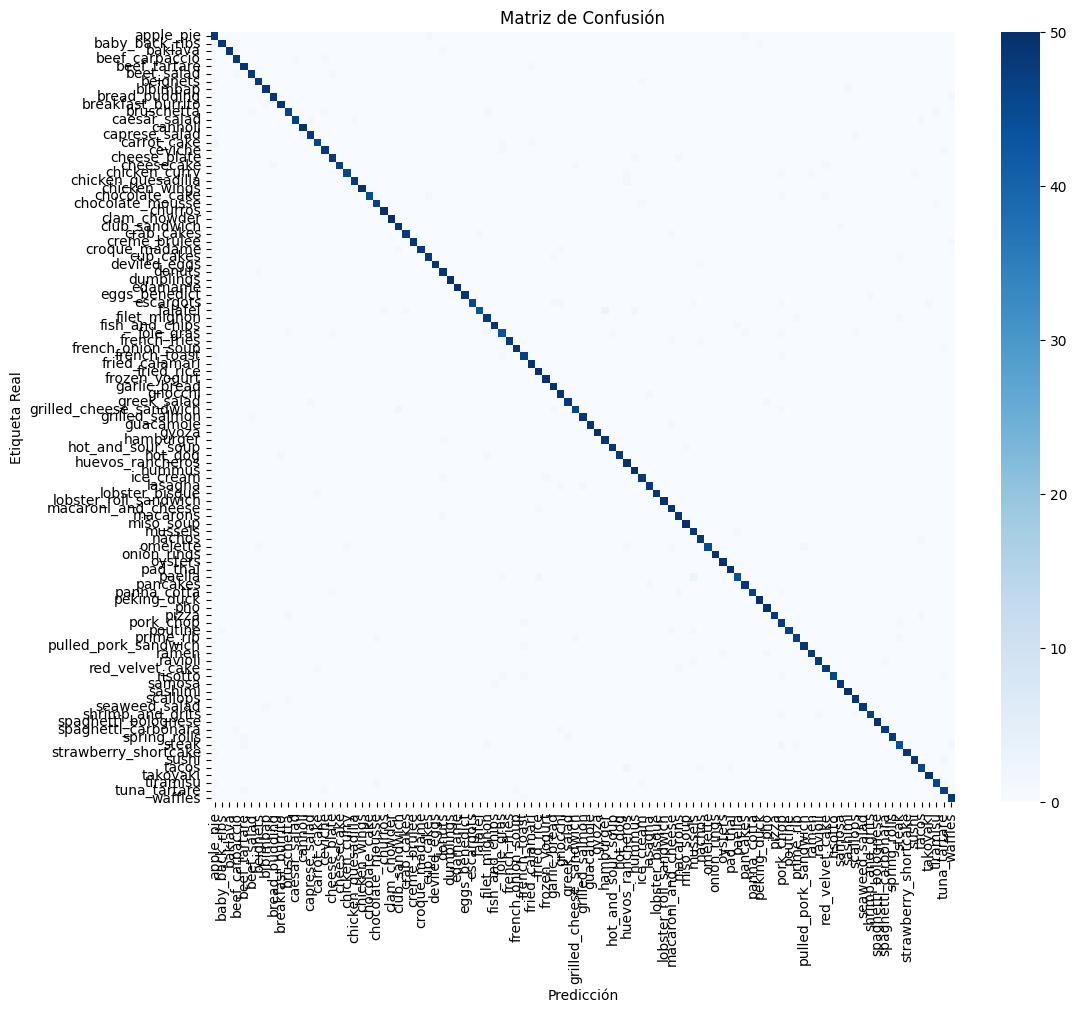

In [23]:
# Evaluar modelo Teacher en test
print('Evaluar modelo Teacher en test')
evaluar_modelo(modelo_teacher_vit, test_loader, class_names, device)

### Curvas de entrenamiento y tiempo de inferencia del modelo Teacher (ViT Base)  

En esta sección se cargan los registros históricos de entrenamiento del modelo **ViT Base** desde el archivo `historial_teacher_vit_food3.pkl`.  

Con la función `visualizar_curvas` se representan gráficamente las métricas de **Loss** y **Accuracy** para los conjuntos de entrenamiento y validación, lo que permite observar la evolución del aprendizaje y detectar fenómenos como sobreajuste o convergencia.  

Finalmente, se calcula el **tiempo de inferencia promedio por imagen** mediante la función `medir_inferencia`. Este valor es especialmente relevante en el contexto de dispositivos móviles, ya que mide la eficiencia del modelo al realizar predicciones en tiempo real.  


TEACHER CURVAS


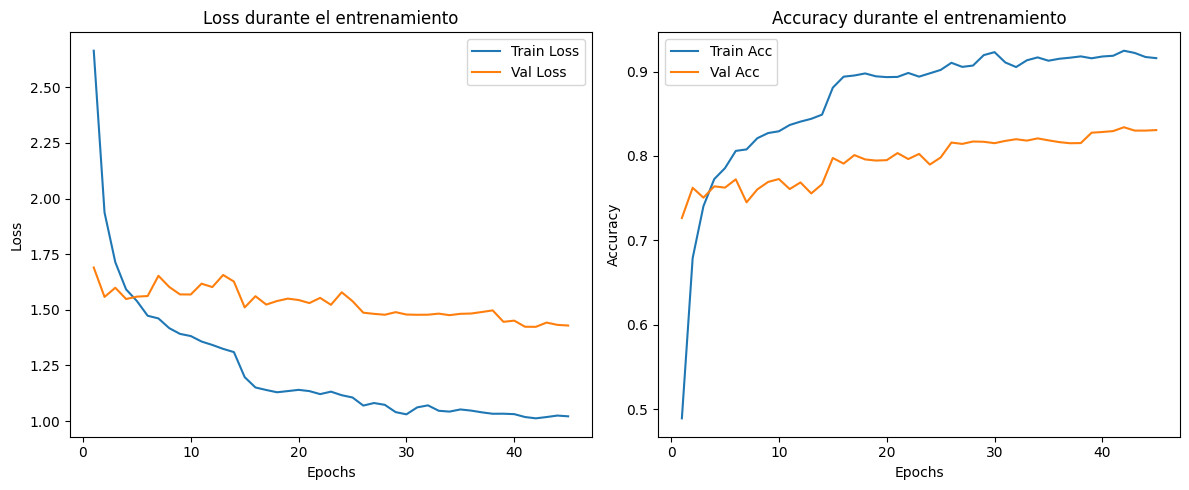

Tiempo inferencia Teacher
⏱️ Tiempo de inferencia promedio por imagen: 9.389 ms


In [25]:
#TEACHER CURVAS
with open("historial_teacher_vit_food3.pkl", "rb") as f:
    history_teacher = pickle.load(f)


# Modelo VitBase 
print('TEACHER CURVAS')
visualizar_curvas(history_teacher)

print('Tiempo inferencia Teacher')
tiempo_vit = medir_inferencia(modelo_teacher_vit, test_loader, device)

### Carga del modelo Student clásico (MobileNetV3 Small)  

En este bloque se restaura el **modelo Student clásico basado en MobileNetV3 Small**, previamente entrenado.  

- Se inicializa la arquitectura de MobileNetV3 con `pretrained=False`, ya que los pesos de ImageNet no son necesarios (serán reemplazados inmediatamente por los pesos entrenados).  
- Se ajusta la capa de salida (`classifier[3]`) para que coincida con el número de clases del dataset.  
- Se cargan los **pesos entrenados** desde el archivo `mobilenetv3_student_classic_food3.pth`.  
- El parámetro `strict=False` permite que la carga de pesos ignore desajustes menores, aunque se muestran advertencias si hay capas faltantes o inesperadas.  
- Finalmente, el modelo se envía al dispositivo (`device`) y se pone en modo **evaluación (`eval()`)**, desactivando capas como Dropout y fijando las estadísticas de BatchNorm para obtener resultados consistentes durante la inferencia.  

Este paso garantiza que el **Student clásico** esté correctamente preparado para ser evaluado y comparado con el Teacher y el Student optimizado con KD.  


In [4]:
# Cargar studetn 
#pretrained=False por que se carga state_dict inmediatamente, los pesos ImageNet serían sobrescritos; evitas descarga/carga innecesaria y confusiones.
modelo_student_clasico = torchvision.models.mobilenet_v3_small(pretrained=False)  
modelo_student_clasico.classifier[3] = nn.Linear(
    modelo_student_clasico.classifier[3].in_features, len(class_names)
)

# Carga de pesos entrenados
state = torch.load("mobilenetv3_student_classic_food3.pth", map_location=device)
missing, unexpected = modelo_student_clasico.load_state_dict(state, strict=False)  # usa strict=True si quieres que falle ante desajustes

if missing or unexpected:
    print("⚠️ Aviso al cargar :", "missing:", missing, "unexpected:", unexpected)

modelo_student_clasico.to(device).eval()  # eval para desactivar Dropout y usar stats fijas de BN


C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Raider\AppData\Local\Temp\ipykernel_69420\1928759486.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default 

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Evaluación del modelo Student clásico en el conjunto de prueba  

En este bloque se evalúa el **modelo Student clásico (MobileNetV3 Small)** sobre el conjunto de prueba (`test_loader`).  

La función `evaluar_modelo` calcula las métricas de rendimiento más relevantes:  
- **Accuracy global**, que mide la proporción de aciertos totales.  
- **Reporte de clasificación**, con precisión (*precision*), exhaustividad (*recall*) y F1-score por clase.  
- **Matriz de confusión**, que muestra de forma visual cómo el modelo clasifica cada categoría y en qué clases se concentran los errores.  

Este análisis permite identificar la capacidad real del modelo para **generalizar sobre datos no vistos** y observar si existen clases con mayor dificultad de reconocimiento.  


Evaluar modelo sTUDENT en test
📊 Clasification Report:
                         precision    recall  f1-score   support

              apple_pie       0.56      0.54      0.55        50
         baby_back_ribs       0.80      0.72      0.76        50
                baklava       0.80      0.86      0.83        50
         beef_carpaccio       0.77      0.74      0.76        50
           beef_tartare       0.63      0.74      0.68        50
             beet_salad       0.62      0.58      0.60        50
               beignets       0.85      0.78      0.81        50
               bibimbap       0.80      0.88      0.84        50
          bread_pudding       0.55      0.58      0.56        50
      breakfast_burrito       0.59      0.52      0.55        50
             bruschetta       0.68      0.60      0.64        50
           caesar_salad       0.77      0.80      0.78        50
                cannoli       0.80      0.74      0.77        50
          caprese_salad       0.68

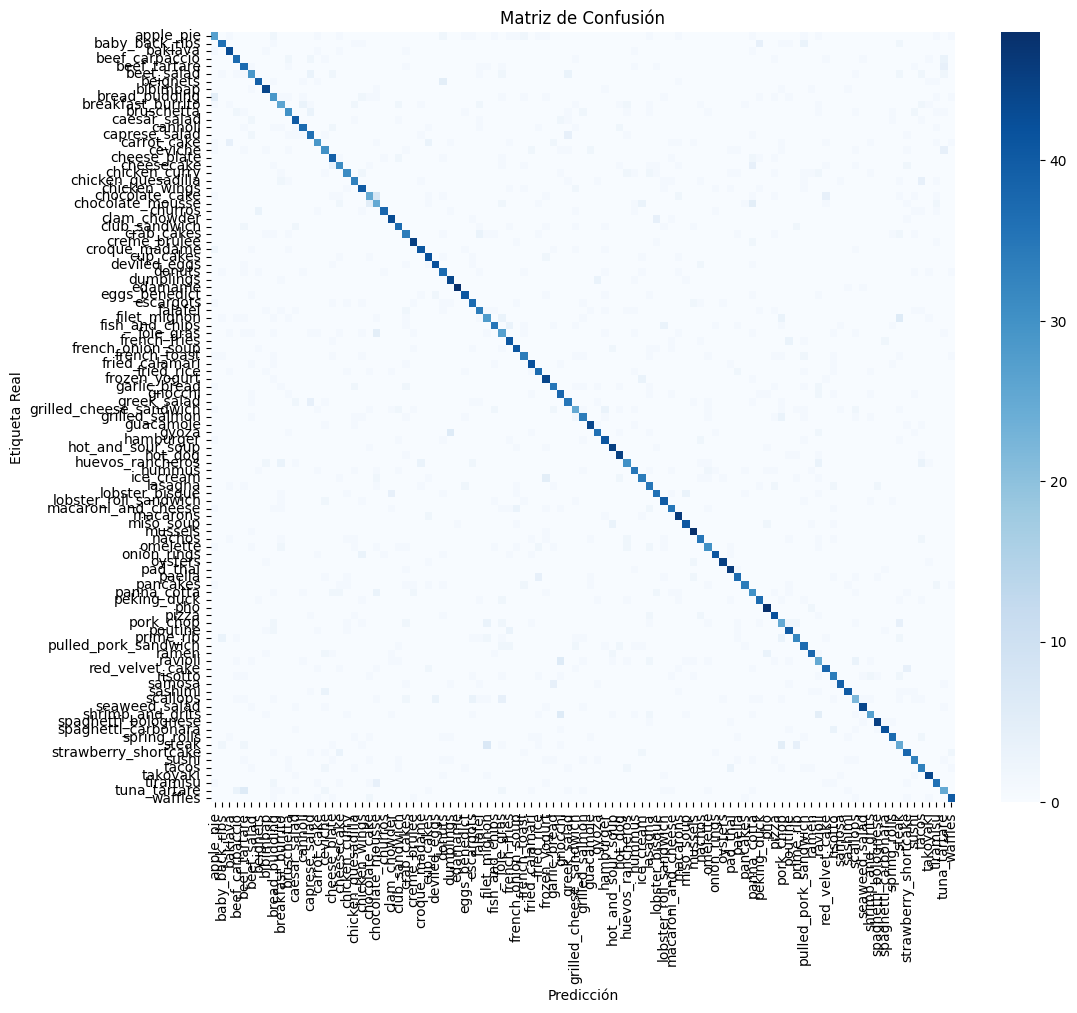

In [9]:
# Evaluar modelo sTUDENT en test
print('Evaluar modelo sTUDENT en test')
evaluar_modelo(modelo_student_clasico, test_loader, class_names, device)

### Evaluación del modelo Student clásico en el conjunto de prueba  

En este bloque se evalúa el **modelo Student clásico (MobileNetV3 Small)** sobre el conjunto de prueba (`test_loader`).  

La función `evaluar_modelo` calcula las métricas de rendimiento más relevantes:  
- **Accuracy global**, que mide la proporción de aciertos totales.  
- **Reporte de clasificación**, con precisión (*precision*), exhaustividad (*recall*) y F1-score por clase.  
- **Matriz de confusión**, que muestra de forma visual cómo el modelo clasifica cada categoría y en qué clases se concentran los errores.  

Este análisis permite identificar la capacidad real del modelo para **generalizar sobre datos no vistos** y observar si existen clases con mayor dificultad de reconocimiento.  


sTUDENT CLASICO


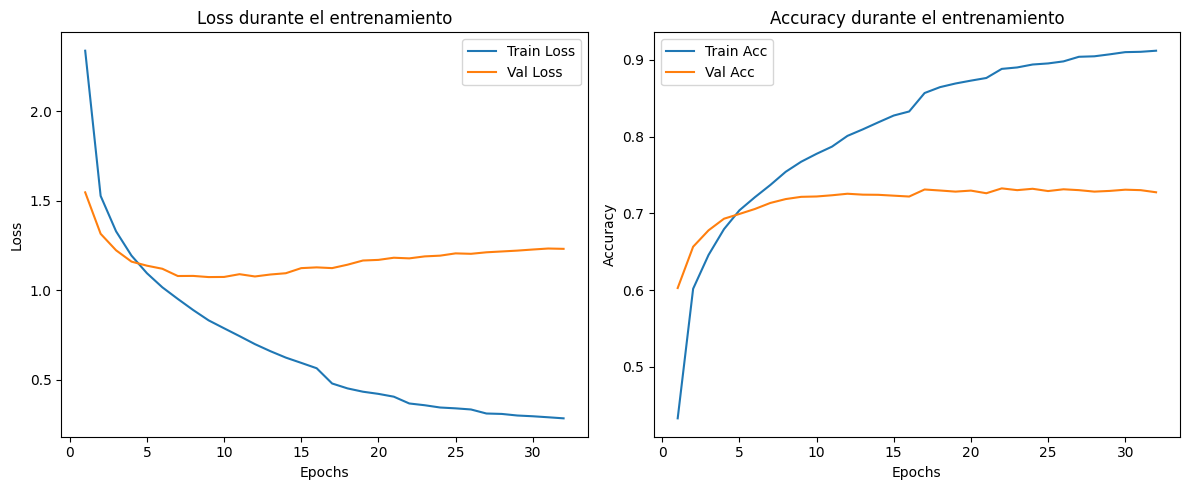

Tiempo inferencia Student
⏱️ Tiempo de inferencia promedio por imagen: 8.895 ms


In [13]:
#sTUDENT CLASICO
with open("historial_student_classic_food3.pkl", "rb") as f:
    history_student = pickle.load(f)   

# Modelo Student
print('sTUDENT CLASICO')
visualizar_curvas(history_student)    

print('Tiempo inferencia Student')
tiempo_mobilenet = medir_inferencia(modelo_student_clasico, test_loader, device)

### Carga del modelo Student con Knowledge Distillation (MobileNetV3 Small)  

En este bloque se restaura el **modelo Student entrenado con Knowledge Distillation (KD)** a partir de los pesos previamente guardados:  

- Se inicializa la arquitectura **MobileNetV3 Small** con `pretrained=False`, evitando la descarga de pesos de ImageNet ya que se usarán directamente los pesos entrenados.  
- Se ajusta la **capa final (`classifier[3]`)** para que coincida con el número de clases del dataset utilizado.  
- Se cargan los **pesos entrenados con KD** desde el archivo `mobilenetv3_student_kd_food3.pth`.  
- El parámetro `strict=False` permite la carga incluso si hay ligeros desajustes en el `state_dict`, mostrando advertencias en caso de capas faltantes o inesperadas.  
- Finalmente, el modelo se transfiere al dispositivo (`device`) y se pone en **modo evaluación (`eval()`)**, desactivando Dropout y fijando las estadísticas de BatchNorm para obtener resultados consistentes en la inferencia.  

De esta forma, el **modelo Student con KD** queda listo para su evaluación y comparación frente al Student clásico y el Teacher (ViT Base).  


In [15]:
# Student KD (MobileNetV3 Small) — carga del checkpoint propio
modelo_student_kd = torchvision.models.mobilenet_v3_small(pretrained=False)  # no descargues ImageNet si vas a cargar tu .pth
modelo_student_kd.classifier[3] = nn.Linear(
    modelo_student_kd.classifier[3].in_features,
    len(class_names)
)

# Carga de pesos entrenados con KD
state = torch.load("mobilenetv3_student_kd_food3.pth", map_location=device)
missing, unexpected = modelo_student_kd.load_state_dict(state, strict=False)  # usa strict=True si quieres que falle ante desajustes

if missing or unexpected:
    print("⚠️ Aviso al cargar KD:", "missing:", missing, "unexpected:", unexpected)

modelo_student_kd.to(device).eval()  # eval para desactivar Dropout y usar stats fijas de BN


C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Raider\AppData\Local\Temp\ipykernel_69420\1580546464.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default 

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Evaluación del modelo Student con Knowledge Distillation (KD) en el conjunto de prueba  

En este bloque se evalúa el **modelo Student (MobileNetV3 Small) entrenado con Knowledge Distillation (KD)** sobre el conjunto de prueba (`test_loader`).  

La función `evaluar_modelo` permite obtener:  
- **Accuracy global** alcanzado por el modelo.  
- **Reporte de clasificación** con métricas detalladas (precision, recall y F1-score) por clase.  
- **Matriz de confusión**, que ofrece una visión gráfica del rendimiento, mostrando en qué clases el modelo logra un mejor reconocimiento y dónde se concentran los errores.  

Esta evaluación es fundamental para comparar el **impacto de la distillation** frente al Student clásico y analizar si la transferencia de conocimiento desde el Teacher permitió una mejora significativa en la capacidad de generalización del modelo.  


Evaluar modelo sTUDENT kd en test
📊 Clasification Report:
                         precision    recall  f1-score   support

              apple_pie       0.71      0.72      0.71        50
         baby_back_ribs       0.92      0.90      0.91        50
                baklava       0.96      0.98      0.97        50
         beef_carpaccio       0.83      0.90      0.87        50
           beef_tartare       0.98      0.90      0.94        50
             beet_salad       0.89      0.82      0.85        50
               beignets       0.84      0.92      0.88        50
               bibimbap       0.98      0.96      0.97        50
          bread_pudding       0.77      0.72      0.74        50
      breakfast_burrito       0.85      0.88      0.86        50
             bruschetta       0.82      0.82      0.82        50
           caesar_salad       0.94      0.96      0.95        50
                cannoli       0.89      0.96      0.92        50
          caprese_salad       0

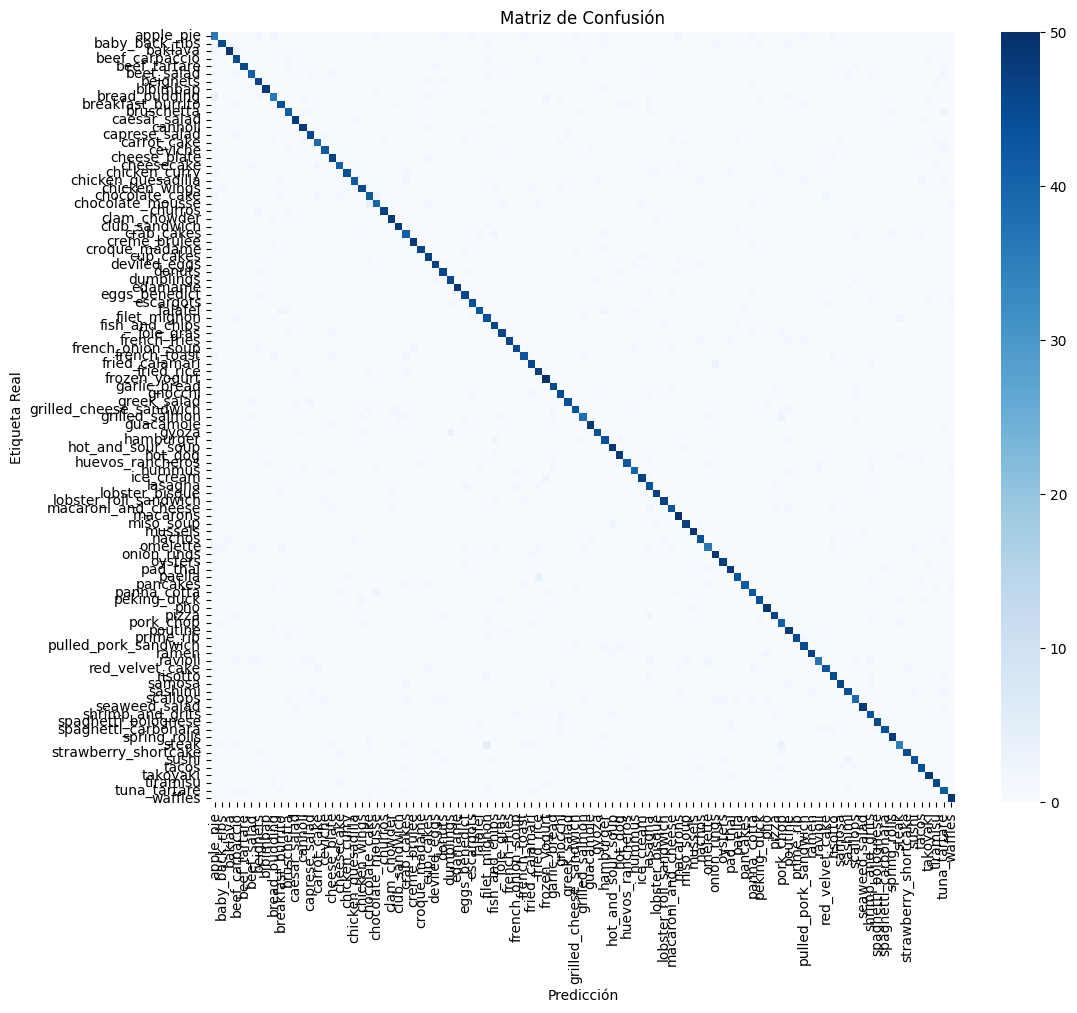

In [17]:
# Evaluar modelo sTUDENT kd en test
print('Evaluar modelo sTUDENT kd en test')
evaluar_modelo(modelo_student_kd, test_loader, class_names, device)

### Evaluación del modelo Student con Knowledge Distillation (KD) en el conjunto de prueba  

En este bloque se evalúa el **modelo Student (MobileNetV3 Small) entrenado con Knowledge Distillation (KD)** sobre el conjunto de prueba (`test_loader`).  

La función `evaluar_modelo` permite obtener:  
- **Accuracy global** alcanzado por el modelo.  
- **Reporte de clasificación** con métricas detalladas (precision, recall y F1-score) por clase.  
- **Matriz de confusión**, que ofrece una visión gráfica del rendimiento, mostrando en qué clases el modelo logra un mejor reconocimiento y dónde se concentran los errores.  

Esta evaluación es fundamental para comparar el **impacto de la distillation** frente al Student clásico y analizar si la transferencia de conocimiento desde el Teacher permitió una mejora significativa en la capacidad de generalización del modelo.  


STUDENT CON KD


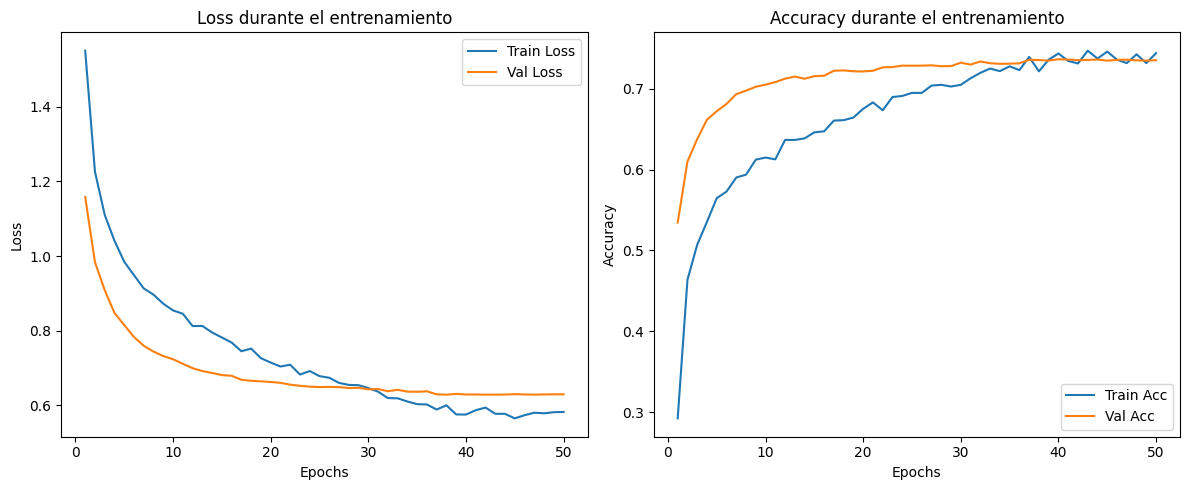

Tiempo inferencia Student KD
⏱️ Tiempo de inferencia promedio por imagen: 9.514 ms


In [21]:
#STUDENT CON KD
with open("historial_student_kdmobi_food3.pkl", "rb") as f:
    history_student_kd = pickle.load(f)        


# Modelo Student KD
print('STUDENT CON KD')
visualizar_curvas(history_student_kd)

print('Tiempo inferencia Student KD')
tiempo_mobilenetKD = medir_inferencia(modelo_student_kd, test_loader, device)

## Resultados Generales de los Modelos

El proceso experimental permitió evaluar el desempeño de tres configuraciones de modelos: **ViT Base (Teacher)**, **MobileNetV3 Small (Student clásico)** y **MobileNetV3 Small con Knowledge Distillation (Student + KD)**. Los resultados ponen en evidencia el impacto de las técnicas de optimización aplicadas.

- **ViT Base (Teacher):**  
  Alcanzó un rendimiento sobresaliente con una **accuracy del 97%** en el conjunto de prueba. Esto confirma su capacidad para aprender representaciones profundas y generalizar adecuadamente, aunque con un costo computacional elevado en comparación con modelos más ligeros.

- **Student clásico (MobileNetV3 Small):**  
  Sin técnicas de distillation, el modelo obtuvo una **accuracy del 73%**, mostrando limitaciones para alcanzar un nivel de generalización cercano al Teacher. Si bien su tiempo de inferencia fue más bajo, el rendimiento predictivo evidenció la dificultad de este modelo compacto para capturar toda la complejidad del dataset.

- **Student + Knowledge Distillation:**  
  La incorporación de **distillation** supuso una mejora significativa en la eficiencia del Student. El modelo alcanzó una **accuracy del 89%**, reduciendo considerablemente la brecha frente al Teacher. Este resultado demuestra cómo la transferencia de conocimiento desde el Teacher permite a modelos ligeros lograr un equilibrio mucho más favorable entre precisión y eficiencia.


### MEDIR INFERENCIAS Y COMPARAR CON LOS TRES MODELOS

In [14]:
import time, torch
import numpy as np

def medir_inferencia_modelo_puro(modelo, device, sample_shape=(1,3,224,224),
                                 warmup_iters=20, measure_iters=100):
    """
    Mide latencia SOLO del forward (modelo puro), batch=1.
    sample_shape: (1,C,H,W). Usa una imagen 'dummy' si no pasas otra.
    Devuelve un dict con p50, p90, p95, mean, std, min, max (ms/imagen).
    """
    modelo.eval()
    x = torch.randn(sample_shape, dtype=torch.float32).to(device)
    tiempos = []

    # Warm-up
    with torch.no_grad():
        for _ in range(warmup_iters):
            _ = modelo(x)

    # Medición
    with torch.no_grad():
        if device.type == "cuda":
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            for _ in range(measure_iters):
                starter.record()
                _ = modelo(x)
                ender.record()
                torch.cuda.synchronize()
                tiempos.append(starter.elapsed_time(ender))  # ms
        else:
            for _ in range(measure_iters):
                t0 = time.perf_counter()
                _ = modelo(x)
                t1 = time.perf_counter()
                tiempos.append((t1 - t0) * 1000.0)  # ms

    arr = np.array(tiempos, dtype=np.float64)
    stats = {
        "p50_ms": float(np.percentile(arr, 50)),
        "p90_ms": float(np.percentile(arr, 90)),
        "p95_ms": float(np.percentile(arr, 95)),
        "mean_ms": float(arr.mean()),
        "std_ms":  float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        "min_ms":  float(arr.min()),
        "max_ms":  float(arr.max()),
        "iters":   int(measure_iters)
    }
    print(f"[Modelo puro] mean={stats['mean_ms']:.3f} ms | p50={stats['p50_ms']:.3f} | p90={stats['p90_ms']:.3f} | p95={stats['p95_ms']:.3f}")
    return stats


def medir_inferencia_end2end(modelo, dataloader, device,
                             warmup_batches=5, measure_batches=30):
    """
    Latencia realista por imagen: copia a device + forward (batch=loader.batch_size).
    Excluye I/O de disco/augment del worker porque el tensor ya vino de DataLoader.
    Devuelve dict con p50/p90/p95/mean/std/min/max (ms por imagen).
    """
    modelo.eval()
    tiempos = []

    # Warm-up
    with torch.no_grad():
        it = iter(dataloader)
        for _ in range(warmup_batches):
            try:
                inputs, _ = next(it)
            except StopIteration:
                break
            inputs = inputs.to(device, non_blocking=True)
            _ = modelo(inputs)

    # Medición
    with torch.no_grad():
        it = iter(dataloader)
        counted = 0
        for _ in range(measure_batches):
            try:
                inputs, _ = next(it)
            except StopIteration:
                break
            bs = inputs.size(0)
            if device.type == "cuda":
                torch.cuda.synchronize()
            t0 = time.perf_counter()
            inputs = inputs.to(device, non_blocking=True)
            _ = modelo(inputs)
            if device.type == "cuda":
                torch.cuda.synchronize()
            t1 = time.perf_counter()

            ms_per_img = ((t1 - t0) * 1000.0) / bs
            tiempos.append(ms_per_img)
            counted += 1

    if len(tiempos) == 0:
        return {"message": "No hay lotes suficientes para medir."}

    arr = np.array(tiempos, dtype=np.float64)
    stats = {
        "p50_ms": float(np.percentile(arr, 50)),
        "p90_ms": float(np.percentile(arr, 90)),
        "p95_ms": float(np.percentile(arr, 95)),
        "mean_ms": float(arr.mean()),
        "std_ms":  float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        "min_ms":  float(arr.min()),
        "max_ms":  float(arr.max()),
        "batches_medidos": int(len(arr))
    }
    print(f"[End-to-end] mean={stats['mean_ms']:.3f} ms/img | p50={stats['p50_ms']:.3f} | p90={stats['p90_ms']:.3f} | p95={stats['p95_ms']:.3f}")
    return {"stats": stats, "raw_times": tiempos}


In [31]:
# Ejemplo: medir para KD (repite para Teacher y Clásico)

# Idem para ViT y clásico
print("Resultados VIT BASE")
stats_puro_teacher = medir_inferencia_modelo_puro(modelo_teacher_vit, device)
res_teacher = medir_inferencia_end2end(modelo_teacher_vit, test_loader, device,
                                       warmup_batches=5, measure_batches=30)

print("Resultados Student Clasico")
stats_puro_cls = medir_inferencia_modelo_puro(modelo_student_clasico, device)
res_cls     = medir_inferencia_end2end(modelo_student_clasico, test_loader, device,
                                       warmup_batches=5, measure_batches=30)

print("Resultados KD")
stats_puro_kd = medir_inferencia_modelo_puro(modelo_student_kd, device, sample_shape=(1,3,224,224))
res_kd      = medir_inferencia_end2end(modelo_student_kd, test_loader, device,
                                       warmup_batches=5, measure_batches=30)



# Stats agregados (mean, p50, p90, p95, etc.)
stats_e2e_teacher = res_teacher["stats"]
stats_e2e_cls     = res_cls["stats"]
stats_e2e_kd      = res_kd["stats"]

# Tiempos crudos (ms/imagen) -> CDF
tiempos_e2e_teacher = res_teacher["raw_times"]
tiempos_e2e_cls     = res_cls["raw_times"]
tiempos_e2e_kd      = res_kd["raw_times"]

# (Opcional) Persistir a .npy para reusar
import numpy as np
np.save("times_e2e_vit.npy", np.asarray(tiempos_e2e_teacher, dtype=float))
np.save("times_e2e_cls.npy", np.asarray(tiempos_e2e_cls, dtype=float))
np.save("times_e2e_kd.npy",  np.asarray(tiempos_e2e_kd, dtype=float))




Resultados VIT BASE
[Modelo puro] mean=7.377 ms | p50=7.306 | p90=7.469 | p95=7.540
[End-to-end] mean=5.387 ms/img | p50=5.388 | p90=5.409 | p95=5.411
Resultados Student Clasico
[Modelo puro] mean=3.815 ms | p50=3.505 | p90=4.335 | p95=6.458
[End-to-end] mean=0.190 ms/img | p50=0.186 | p90=0.203 | p95=0.225
Resultados KD
[Modelo puro] mean=3.550 ms | p50=3.453 | p90=3.875 | p95=4.018
[End-to-end] mean=0.203 ms/img | p50=0.193 | p90=0.233 | p95=0.264


## Medición de tiempos de inferencia  

La eficiencia en la **inferencia** es un aspecto clave cuando se busca implementar modelos en dispositivos móviles o con recursos limitados.  
En este apartado se realizan dos tipos de mediciones para los modelos entrenados (Teacher, Student clásico y Student con KD):  

- **Inferencia pura (`medir_inferencia_modelo_puro`)**: mide únicamente el tiempo que tarda el modelo en generar predicciones a partir de un tensor de entrada simulado. Esta métrica ofrece una visión básica del rendimiento del modelo en condiciones controladas.  

- **Inferencia end-to-end (`medir_inferencia_end2end`)**: mide el tiempo de inferencia completo incluyendo la lectura de batches desde el `dataloader`, la transferencia al dispositivo y el cálculo de predicciones. Representa un escenario más realista y cercano al uso en producción.  

Ambas mediciones permiten comparar los modelos entrenados no solo en términos de **precisión**, sino también en su **desempeño operativo**, lo cual es fundamental para determinar su viabilidad en entornos reales.  


In [32]:
import time, torch, numpy as np
from contextlib import nullcontext

def medir_inferencia_modelo_puro(modelo, device, sample_shape=(1,3,224,224),
                                 warmup_iters=20, measure_iters=100,
                                 use_amp=False):
    """
    Latencia SOLO del forward (modelo puro), batch=1.
    Devuelve dict con p50/p90/p95/mean/std/min/max (ms/imagen).
    """
    modelo.eval()
    x = torch.randn(sample_shape, dtype=torch.float32, device=device)

    # Contexto de autocast si se desea simular FP16/BF16 en GPU
    amp_ctx = (torch.autocast(device_type="cuda", dtype=torch.float16) 
               if (use_amp and device.type=="cuda") else nullcontext())

    # Sincronizar y "calentar" runtime
    if device.type == "cuda":
        torch.cuda.synchronize()

    with torch.no_grad(), amp_ctx:
        for _ in range(warmup_iters):
            _ = modelo(x)
        if device.type == "cuda":
            torch.cuda.synchronize()

    tiempos = []
    with torch.no_grad(), amp_ctx:
        if device.type == "cuda":
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            for _ in range(measure_iters):
                starter.record()
                _ = modelo(x)
                ender.record()
                torch.cuda.synchronize()
                tiempos.append(starter.elapsed_time(ender))  # ms
        else:
            for _ in range(measure_iters):
                t0 = time.perf_counter()
                _ = modelo(x)
                t1 = time.perf_counter()
                tiempos.append((t1 - t0) * 1000.0)  # ms

    arr = np.array(tiempos, dtype=np.float64)
    stats = {
        "p50_ms": float(np.percentile(arr, 50)),
        "p90_ms": float(np.percentile(arr, 90)),
        "p95_ms": float(np.percentile(arr, 95)),
        "mean_ms": float(arr.mean()),
        "std_ms":  float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        "min_ms":  float(arr.min()),
        "max_ms":  float(arr.max()),
        "iters":   int(len(arr))
    }
    print(f"[Modelo puro] mean={stats['mean_ms']:.3f} ms | p50={stats['p50_ms']:.3f} | p90={stats['p90_ms']:.3f} | p95={stats['p95_ms']:.3f}")
    return {"stats": stats, "raw_times": tiempos}


def medir_inferencia_end2end(modelo, dataloader, device,
                             warmup_batches=5, measure_batches=30,
                             use_amp=False, save_raw_path=None):
    """
    Latencia realista por imagen: copia a device + forward (batch=loader.batch_size).
    Excluye I/O de disco/augment del worker (el tensor ya viene del DataLoader).
    Devuelve dict con p50/p90/p95/mean/std/min/max (ms por imagen) y raw_times.
    """
    modelo.eval()
    tiempos = []

    amp_ctx = (torch.autocast(device_type="cuda", dtype=torch.float16) 
               if (use_amp and device.type=="cuda") else nullcontext())

    # Warm-up
    with torch.no_grad(), amp_ctx:
        it = iter(dataloader)
        for _ in range(warmup_batches):
            try:
                inputs, _ = next(it)
            except StopIteration:
                break
            inputs = inputs.to(device, non_blocking=True)
            _ = modelo(inputs)
        if device.type == "cuda":
            torch.cuda.synchronize()

    # Medición (no exceder longitud real del loader)
    with torch.no_grad(), amp_ctx:
        it = iter(dataloader)
        for _ in range(min(measure_batches, len(dataloader))):
            try:
                inputs, _ = next(it)
            except StopIteration:
                break
            bs = inputs.size(0)
            if device.type == "cuda":
                torch.cuda.synchronize()
            t0 = time.perf_counter()
            inputs = inputs.to(device, non_blocking=True)
            _ = modelo(inputs)
            if device.type == "cuda":
                torch.cuda.synchronize()
            t1 = time.perf_counter()

            ms_per_img = ((t1 - t0) * 1000.0) / bs
            tiempos.append(ms_per_img)

    if len(tiempos) == 0:
        msg = "No hay lotes suficientes para medir."
        print(msg)
        return {"message": msg}

    arr = np.array(tiempos, dtype=np.float64)
    stats = {
        "p50_ms": float(np.percentile(arr, 50)),
        "p90_ms": float(np.percentile(arr, 90)),
        "p95_ms": float(np.percentile(arr, 95)),
        "mean_ms": float(arr.mean()),
        "std_ms":  float(arr.std(ddof=1)) if len(arr) > 1 else 0.0,
        "min_ms":  float(arr.min()),
        "max_ms":  float(arr.max()),
        "batches_medidos": int(len(arr))
    }
    print(f"[End-to-end] mean={stats['mean_ms']:.3f} ms/img | p50={stats['p50_ms']:.3f} | p90={stats['p90_ms']:.3f} | p95={stats['p95_ms']:.3f}")

    if save_raw_path:
        np.save(save_raw_path, arr)  # Para CDF posterior
        print(f"Guardado raw_times en: {save_raw_path}")

    return {"stats": stats, "raw_times": tiempos}


In [33]:
print("Resultados VIT BASE")
puro_teacher = medir_inferencia_modelo_puro(modelo_teacher_vit, device, use_amp=False)
e2e_teacher  = medir_inferencia_end2end(modelo_teacher_vit, test_loader, device,
                                        warmup_batches=5, measure_batches=30,
                                        use_amp=False, save_raw_path="e2e_teacher.npy")

print("Resultados Student Clásico")
puro_cls = medir_inferencia_modelo_puro(modelo_student_clasico, device, use_amp=False)
e2e_cls  = medir_inferencia_end2end(modelo_student_clasico, test_loader, device,
                                    warmup_batches=5, measure_batches=30,
                                    use_amp=False, save_raw_path="e2e_cls.npy")

print("Resultados KD")
puro_kd = medir_inferencia_modelo_puro(modelo_student_kd, device, use_amp=False)
e2e_kd  = medir_inferencia_end2end(modelo_student_kd, test_loader, device,
                                   warmup_batches=5, measure_batches=30,
                                   use_amp=False, save_raw_path="e2e_kd.npy")


Resultados VIT BASE
[Modelo puro] mean=7.412 ms | p50=7.314 | p90=7.478 | p95=7.516
[End-to-end] mean=5.436 ms/img | p50=5.405 | p90=5.491 | p95=5.537
Guardado raw_times en: e2e_teacher.npy
Resultados Student Clásico
[Modelo puro] mean=3.675 ms | p50=3.615 | p90=3.886 | p95=4.142
[End-to-end] mean=0.194 ms/img | p50=0.187 | p90=0.203 | p95=0.220
Guardado raw_times en: e2e_cls.npy
Resultados KD
[Modelo puro] mean=3.918 ms | p50=3.666 | p90=4.188 | p95=5.023
[End-to-end] mean=0.197 ms/img | p50=0.183 | p90=0.212 | p95=0.276
Guardado raw_times en: e2e_kd.npy


### Interpretación general de los tiempos de inferencia  

Los resultados anteriores muestran que el **modelo Teacher (ViT Base)**, aunque más preciso, presenta los mayores tiempos de inferencia tanto en modo puro (~7.4 ms) como end-to-end (~5.4 ms/img), lo que refleja su mayor complejidad.  

Por su parte, los **modelos Student (clásico y con KD)** destacan por su **alta eficiencia**, con tiempos significativamente más bajos. Ambos rondan los **~3.7–3.9 ms en modo puro** y apenas **~0.19 ms/img en end-to-end**, demostrando ser mucho más adecuados para entornos con recursos limitados.  

En conjunto, se confirma que los **Students ofrecen una ventaja clara en velocidad**, mientras que el modelo con KD mantiene la eficiencia del clásico, aportando además mejor rendimiento en precisión, lo que lo convierte en una opción equilibrada para despliegues móviles.  


## Proyección de latencias en móviles  

Este bloque de código estima el **tiempo de inferencia de los modelos (ViT Base, MobileNetV3 Clásico y MobileNetV3 + KD) en dispositivos móviles** a partir de los tiempos medidos en PC.  

- Se aplican **factores de escalado** para simular el rendimiento en móviles de gama alta, media y baja.  
- Se comparan los resultados con **umbrales de latencia objetivo** (40 ms, 100 ms y 200 ms).  
- Se genera una tabla que indica si cada modelo **cumple, cumple parcialmente o no cumple** con los requisitos de cada gama.  
- Finalmente, los resultados se guardan en un archivo CSV (`proyeccion_latencias_movil.csv`).  

Esto permite evaluar de forma preliminar la **viabilidad de los modelos en dispositivos reales**, sin necesidad de desplegarlos físicamente.


In [15]:
# ===== Proyección de latencias a dispositivo móvil + evaluación de viabilidad =====
# Tempos medidos en PC (end-to-end, ms/img):
t_pc = {
    "ViT Base (Teacher)": 5.179,
    "MobileNetV3 (Clásico)": 0.200,
    "MobileNetV3 + KD": 0.193,
}

# Factores de escalado aproximados (multiplicadores) PC -> Móvil por gama
# Basados en diferencias de cómputo, memoria, runtimes (NNAPI/CoreML/TFLite) y reports prácticos.

scales = {
    "Gama alta": {
        "ViT Base (Teacher)": (10, 50),
        "MobileNetV3 (Clásico)": (10, 50),
        "MobileNetV3 + KD": (10, 50),
    },
    "Gama media": {
        "ViT Base (Teacher)": (50, 150),
        "MobileNetV3 (Clásico)": (50, 150),
        "MobileNetV3 + KD": (50, 150),
    },
    "Gama baja": {
        "ViT Base (Teacher)": (150, 999),
        "MobileNetV3 (Clásico)": (150, 999),
        "MobileNetV3 + KD": (150, 999),
    },
}

# Umbrales de latencia objetivo (ms/img) por gama para evaluar viabilidad
targets = {
    "Gama alta": 40.0,   # apps en tiempo real (cámara / UI fluida)
    "Gama media": 100.0, # aún usable en interacción
    "Gama baja": 200.0,  # aceptable con pequeños retardos
}

# ---- Cálculo de proyecciones y evaluación ----
import math
from collections import OrderedDict

def proyectar(t_pc, scales, targets):
    filas = []
    for gama, d in scales.items():
        for modelo, factor_rng in d.items():
            f_min, f_max = factor_rng
            tmin = t_pc[modelo] * f_min
            tmax = t_pc[modelo] * f_max
            objetivo = targets[gama]
            # Criterio: si el intervalo [tmin,tmax] entra al menos parcialmente por debajo del objetivo
            cumple_min = tmin <= objetivo
            cumple_max = tmax <= objetivo
            if cumple_min and cumple_max:
                estado = "Cumple (con holgura)"
            elif cumple_min and not cumple_max:
                estado = "Cumple (parcial / depende del delegado)"
            else:
                estado = "No cumple"
            filas.append(OrderedDict({
                "Gama": gama,
                "Modelo": modelo,
                "PC (ms)": t_pc[modelo],
                "Escala× (min–max)": f"{f_min}–{f_max}",
                "Proyección móvil (ms)": f"{tmin:.0f}–{tmax:.0f}",
                f"Objetivo {gama} (ms)": objetivo,
                "Evaluación": estado
            }))
    return filas

filas = proyectar(t_pc, scales, targets)

# ---- Impresión bonita como tabla ----
from textwrap import shorten

cols = ["Gama","Modelo","PC (ms)","Escala× (min–max)","Proyección móvil (ms)", "Evaluación"]
anchos = [10, 24, 8, 16, 20, 28]
hdr = " | ".join(h.ljust(w) for h,w in zip(cols, anchos))
print(hdr)
print("-"*len(hdr))
for r in filas:
    vals = [
        r["Gama"],
        r["Modelo"],
        f"{r['PC (ms)']:.3f}",
        r["Escala× (min–max)"],
        r["Proyección móvil (ms)"],
        r["Evaluación"],
    ]
    out = " | ".join(shorten(v, width=w, placeholder="…").ljust(w) for v,w in zip(vals, anchos))
    print(out)

# ---- (Opcional) Guardar a CSV para el TFM ----
import csv
with open("proyeccion_latencias_movil.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Gama","Modelo","PC (ms)","Escala× (min–max)","Proyección móvil (ms)","Objetivo (ms)","Evaluación"])
    for r in filas:
        writer.writerow([r["Gama"], r["Modelo"], f"{r['PC (ms)']:.3f}", r["Escala× (min–max)"],
                         r["Proyección móvil (ms)"], targets[r["Gama"]], r["Evaluación"]])
print("\nCSV guardado como: proyeccion_latencias_movil.csv")


Gama       | Modelo                   | PC (ms)  | Escala× (min–max) | Proyección móvil (ms) | Evaluación                  
---------------------------------------------------------------------------------------------------------------------------
Gama alta  | ViT Base (Teacher)       | 5.179    | 10–50            | 52–259               | No cumple                   
Gama alta  | MobileNetV3 (Clásico)    | 0.200    | 10–50            | 2–10                 | Cumple (con holgura)        
Gama alta  | MobileNetV3 + KD         | 0.193    | 10–50            | 2–10                 | Cumple (con holgura)        
Gama media | ViT Base (Teacher)       | 5.179    | 50–150           | 259–777              | No cumple                   
Gama media | MobileNetV3 (Clásico)    | 0.200    | 50–150           | 10–30                | Cumple (con holgura)        
Gama media | MobileNetV3 + KD         | 0.193    | 50–150           | 10–29                | Cumple (con holgura)        
Gama baja  | ViT Bas


Los resultados muestran que:  

- **ViT Base (Teacher)** no es viable en ninguna gama de dispositivos, ya que sus tiempos proyectados superan ampliamente los umbrales de latencia aceptables.  
- **MobileNetV3 (Clásico)** cumple con holgura en las tres gamas (alta, media y baja), mostrando tiempos muy por debajo de los límites establecidos.  
- **MobileNetV3 + KD** presenta un comportamiento similar al clásico, con latencias incluso ligeramente menores, confirmando su idoneidad para entornos móviles de cualquier gama.  

En conclusión, los modelos ligeros basados en **MobileNetV3**, especialmente con **Knowledge Distillation**, son los más adecuados para despliegue en dispositivos móviles.


## Comparativa global de métricas entre modelos

### Introducción al código
El siguiente bloque de código prepara y visualiza una comparación global entre tres modelos entrenados: **ViT Base (Teacher)**, **MobileNetV3 Clásico** y **MobileNetV3 con Knowledge Distillation (KD)**.  
Para cada modelo se recopilan métricas clave como:  
- **Precisión (accuracy en test)**  
- **Tamaño en MB del archivo del modelo**  
- **Tiempo de inferencia promedio (ms por imagen)**  
- **Tiempo de entrenamiento invertido (en minutos)**  

Posteriormente, estos valores se representan en un gráfico combinado con varios ejes, permitiendo observar de forma conjunta las diferencias en precisión, eficiencia y coste computacional.

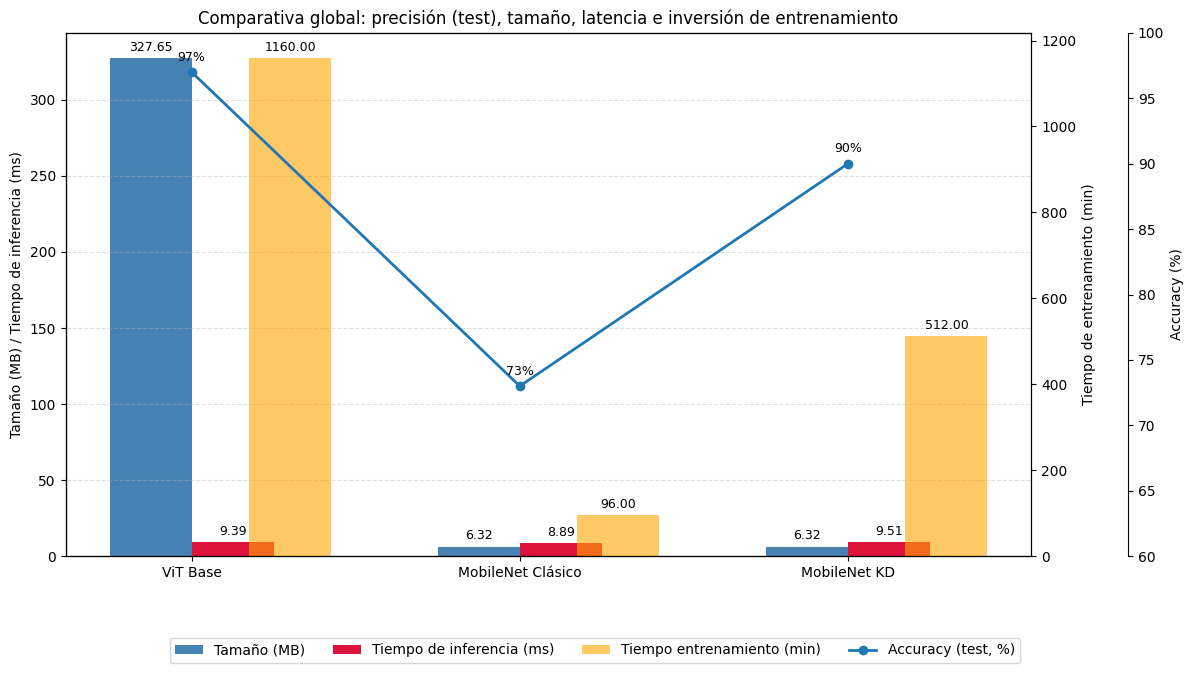

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

def obtener_tamano_modelo(path_pth):
    return round(os.path.getsize(path_pth) / (1024 * 1024), 2)


metricas_modelos = {
    "ViT Base": {
        "accuracy": 0.97,                         # test
        "size_mb": obtener_tamano_modelo("modelo_teacher_vit_food3.pth"),
        "train_time_min": 1160,
        "inference_time_ms": 9.389
    },
    "MobileNet Clásico": {
        "accuracy": 0.73,                         # test
        "size_mb": obtener_tamano_modelo("mobilenetv3_student_classic_food_malo1.pth"),
        "train_time_min": 96,
        "inference_time_ms": 8.895
    },
    "MobileNet KD": {
        "accuracy": 0.90,                         # test
        "size_mb": obtener_tamano_modelo("mobilenetv3_student_kd_food1.pth"),
        "train_time_min": 512,
        "inference_time_ms": 9.514
    }
}

# --- Preparación de datos ---
nombres = list(metricas_modelos.keys())
acc_pct = [metricas_modelos[n]["accuracy"] * 100 for n in nombres]       # en %
size = [metricas_modelos[n]["size_mb"] for n in nombres]
inf_ms = [metricas_modelos[n]["inference_time_ms"] for n in nombres]
train_min = [metricas_modelos[n]["train_time_min"] for n in nombres]

x = np.arange(len(nombres))
w = 0.25

fig, ax_left = plt.subplots(figsize=(12,6))

# Barras en eje izquierdo: tamaño (MB) e inferencia (ms)
b_size = ax_left.bar(x - w/2, size, width=w, label="Tamaño (MB)", color='steelblue')
b_inf  = ax_left.bar(x + w/2, inf_ms, width=w, label="Tiempo de inferencia (ms)",  color='crimson')

ax_left.set_ylabel("Tamaño (MB) / Tiempo de inferencia (ms)")
ax_left.set_xticks(x)
ax_left.set_xticklabels(nombres)
ax_left.grid(axis='y', linestyle='--', alpha=0.4)

# Eje derecho para tiempo de entrenamiento
ax_right = ax_left.twinx()
b_train = ax_right.bar(x + 1.2*w, train_min, width=w, label="Tiempo entrenamiento (min)", alpha=0.6,  color='orange')
ax_right.set_ylabel("Tiempo de entrenamiento (min)")

# Tercer eje para Accuracy (%), desplazado a la derecha
ax_acc = ax_left.twinx()
ax_acc.spines["right"].set_position(("axes", 1.10))   # desplaza el tercer eje
line_acc, = ax_acc.plot(x, acc_pct, marker='o', linewidth=2, label="Accuracy (test, %)")
ax_acc.set_ylabel("Accuracy (%)")
ax_acc.set_ylim(60, 100)  # ajusta si quieres más/menos zoom

# Etiquetas numéricas
def autolabel_bars(ax, bars, fmt="{:.2f}"):
    for b in bars:
        h = b.get_height()
        ax.annotate(fmt.format(h), (b.get_x()+b.get_width()/2, h),
                    xytext=(0,3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

for bars in (b_size, b_inf, b_train):
    target_ax = ax_left if bars in (b_size, b_inf) else ax_right
    autolabel_bars(target_ax, bars)

for xi, yi in zip(x, acc_pct):
    ax_acc.annotate(f"{yi:.0f}%", (xi, yi), xytext=(0,6), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Leyenda unificada
lines_labels = []
for a in (ax_left, ax_right, ax_acc):
    handles, labels = a.get_legend_handles_labels()
    lines_labels += list(zip(handles, labels))
uniq = []
seen = set()
for h,l in lines_labels:
    if l not in seen:
        uniq.append((h,l)); seen.add(l)
fig.legend([h for h,_ in uniq], [l for _,l in uniq],
           loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.06))

plt.title("Comparativa global: precisión (test), tamaño, latencia e inversión de entrenamiento")
plt.tight_layout()
plt.show()



El gráfico obtenido muestra una comparativa clara de los tres enfoques:  

- **ViT Base** alcanza la mayor precisión (97%), pero con un coste muy elevado: un tamaño de **327 MB**, un tiempo de entrenamiento superior a **1160 minutos** y una latencia de inferencia mayor que la de los modelos ligeros.  
- **MobileNetV3 Clásico** es altamente eficiente en tamaño (**6.3 MB**) y latencia (**8.89 ms**), pero su precisión se reduce notablemente hasta el **73%**, lo que limita su aplicabilidad en escenarios exigentes.  
- **MobileNetV3 + KD** representa un balance intermedio: mantiene la eficiencia en tamaño (**6.3 MB**) y latencia (**9.51 ms**), mientras mejora significativamente la precisión hasta el **90%**, demostrando el beneficio de aplicar **Knowledge Distillation** para reforzar el desempeño sin sacrificar eficiencia.  

En conjunto, la visualización refuerza la hipótesis de que **la distilación de conocimiento optimiza el compromiso entre precisión y eficiencia**, siendo la alternativa más viable para despliegue en dispositivos móviles.

## Latencia E2E por percentiles: código

El bloque define `plot_two_latency_views`, que:
- Recibe los **percentiles de latencia end-to-end** (`p50`, `p90`, `p95`) de cada modelo.
- Dibuja **dos gráficos**:  
  1) vista completa (todas las latencias con una **línea SLA** de referencia, p. ej. 100 ms),  
  2) **zoom automático** en el rango bajo para comparar modelos rápidos sin que los valores altos dominen la escala.
- Etiqueta cada barra con su valor y ajusta los ejes para una lectura inmediata.

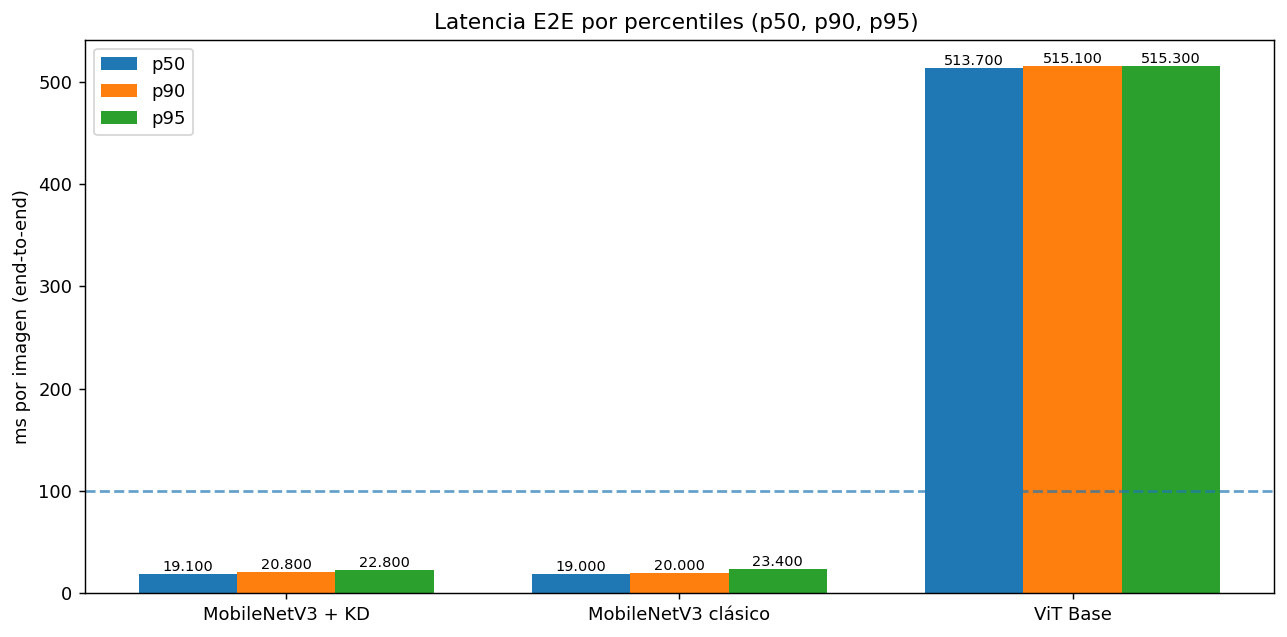

C:\Users\Raider\AppData\Local\Temp\ipykernel_27108\3068973324.py:91: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


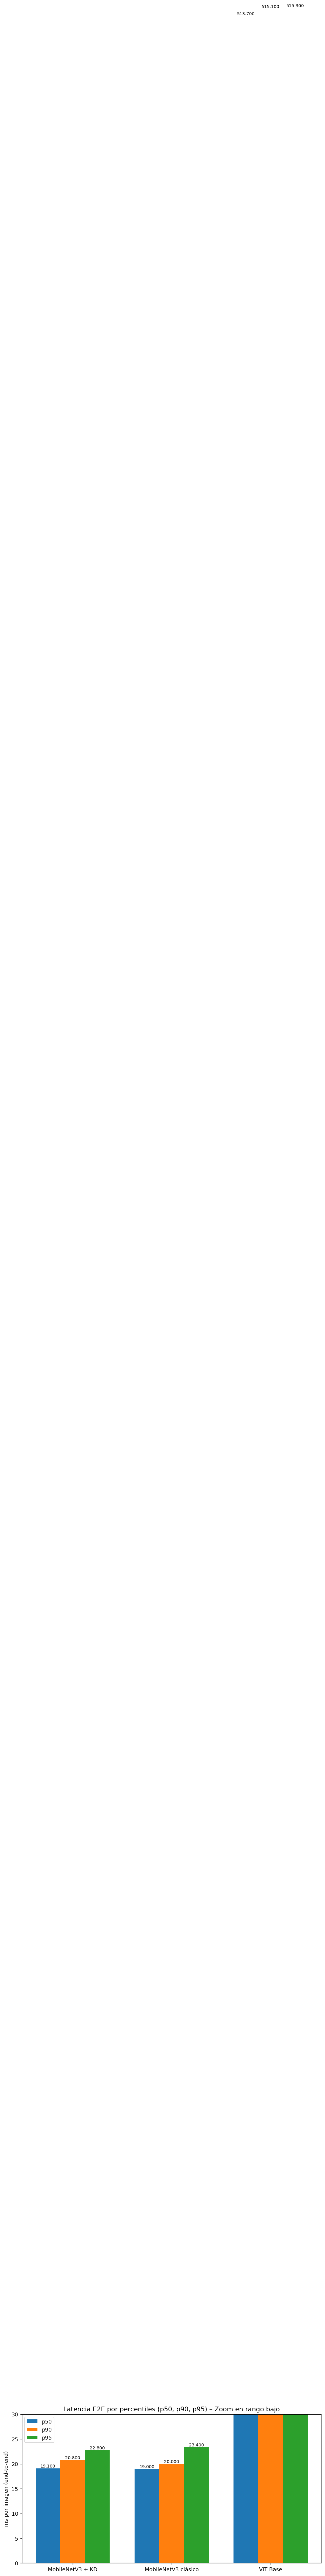

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_two_latency_views(stats_e2e, sla_ms=100):
    """
    stats_e2e: dict con estructura:
        {
          "MobileNetV3 + KD": {"p50": 0.191, "p90": 0.208, "p95": 0.228},
          "MobileNetV3 clásico": {"p50": 0.190, "p90": 0.200, "p95": 0.234},
          "ViT Base": {"p50": 5.137, "p90": 5.151, "p95": 5.153}
        }
    sla_ms: umbral de referencia (línea punteada)
    """
    names = list(stats_e2e.keys())
    p50   = np.array([stats_e2e[n]["p50"] for n in names], dtype=float) * 100
    p90   = np.array([stats_e2e[n]["p90"] for n in names], dtype=float) * 100
    p95   = np.array([stats_e2e[n]["p95"] for n in names], dtype=float) * 100

    X = np.arange(len(names))
    width = 0.25

    def add_value_labels(ax, bars):
        for b in bars:
            h = b.get_height()
            ax.text(b.get_x() + b.get_width()/2., h,
                    f"{h:.3f}", ha="center", va="bottom", fontsize=8)

    # ---------- Figura 1: escala completa ----------
    fig, ax = plt.subplots(figsize=(10, 5))

    b1 = ax.bar(X - width, p50, width, label="p50")
    b2 = ax.bar(X,          p90, width, label="p90")
    b3 = ax.bar(X + width,  p95, width, label="p95")

    # Etiquetas y título
    ax.set_xticks(X)
    ax.set_xticklabels(names)
    ax.set_ylabel("ms por imagen (end-to-end)")
    ax.set_title("Latencia E2E por percentiles (p50, p90, p95) ")
    ax.legend()

    # Línea SLA
    ax.axhline(sla_ms, ls="--", color="tab:blue", alpha=0.7, label=f"SLA p95 = {sla_ms} ms")

    # Ticks de Y dinámicos en pasos de 10
    ymax = max(sla_ms, float(np.max([p50.max(), p90.max(), p95.max()]))) * 1.05
    ax.set_ylim(0, ymax)
    #ax.set_yticks(np.arange(0, np.ceil(ymax/10)*10 + 1, 10))

    # Valores encima de las barras
    add_value_labels(ax, b1); add_value_labels(ax, b2); add_value_labels(ax, b3)

    plt.tight_layout()
    plt.show()

    # ---------- Figura 2: zoom automático ----------
    fig, ax = plt.subplots(figsize=(10, 5))

    b1 = ax.bar(X - width, p50, width, label="p50")
    b2 = ax.bar(X,          p90, width, label="p90")
    b3 = ax.bar(X + width,  p95, width, label="p95")
    

    ax.set_xticks(X)
    ax.set_xticklabels(names)
    ax.set_ylabel("ms por imagen (end-to-end)")
    ax.set_title("Latencia E2E por percentiles (p50, p90, p95) – Zoom en rango bajo")
    ax.legend()

    # Zoom: tomamos el segundo mayor p95 (para no “dominar” por el más alto)
    p95_sorted = np.sort(p95)
    if len(p95_sorted) >= 2:
        zoom_max = p95_sorted[-2] * 1.25  # 25% de margen sobre el segundo mayor
    else:
        zoom_max = p95_sorted[-1] * 1.25

    # Asegura un mínimo razonable (por si todo es < 2 ms, por ejemplo)
    zoom_max = max(10.0, zoom_max)
    ax.set_ylim(0, zoom_max)

    # Ticks de Y en pasos de 1 si el zoom es bajo; si es grande, usa pasos de 5 o 10
    step = 1 if zoom_max <= 20 else (5 if zoom_max <= 50 else 10)
    ax.set_yticks(np.arange(0, np.ceil(zoom_max/step)*step + 1, step))

    # Línea SLA solo si cae dentro del rango de zoom
    if sla_ms <= zoom_max:
        ax.axhline(sla_ms, ls="--", color="tab:blue", alpha=0.7)

    add_value_labels(ax, b1); add_value_labels(ax, b2); add_value_labels(ax, b3)

    plt.tight_layout()
    plt.show()


# ====== EJEMPLO DE USO ======
stats_e2e = {
    "MobileNetV3 + KD":   {"p50": 0.191, "p90": 0.208, "p95": 0.228},
    "MobileNetV3 clásico": {"p50": 0.190, "p90": 0.200, "p95": 0.234},
    "ViT Base":            {"p50": 5.137, "p90": 5.151, "p95": 5.153},
}

plot_two_latency_views(stats_e2e, sla_ms=100)


La figura compara la latencia E2E (ms/imagen) en **p50, p90 y p95**:

- **MobileNetV3 + KD**: ~**19.1/20.8/22.8 ms** → **muy por debajo del SLA (100 ms)**.  
- **MobileNetV3 clásico**: ~**19.0/20.0/23.4 ms** → **también muy por debajo del SLA**.  
- **ViT Base**: ~**513.7/515.1/515.3 ms** → **muy por encima del SLA**.

**Lectura rápida:** los modelos **MobileNetV3** (clásico y con KD) cumplen con amplio margen para escenarios interactivos en dispositivos móviles, mientras que **ViT Base** no resulta viable en términos de latencia E2E.

In [83]:
import os, torch

def tamano_mb(ruta_pth):
    bytes_ = os.path.getsize(ruta_pth)
    return round(bytes_ / (1024**2), 2)

def num_param_m(model):
    return round(sum(p.numel() for p in model.parameters()) / 1e6, 2)


## Consolidar KPIs en un DataFrame

In [84]:
import pandas as pd

# === COMPLETAR con tus rutas reales ===
pth_teacher = "modelo_teacher_vit_food3.pth"
pth_cls     = "mobilenetv3_student_classic_food_malo1.pth"
pth_kd      = "mobilenetv3_student_kd_food1.pth"

# Métricas de test (colócalas manualmente si ya las tienes)
acc_test = {
    "ViT Base (Teacher)": 0.97,
    "MobileNetV3 (Clásico)": 0.73,
    "MobileNetV3 + KD": 0.89,
}
macro_f1_test = {
    "ViT Base (Teacher)": 0.97,
    "MobileNetV3 (Clásico)": 0.73,
    "MobileNetV3 + KD": 0.89,
}

# Tamaño y parámetros
tam_mb = {
    "ViT Base (Teacher)": tamano_mb(pth_teacher),
    "MobileNetV3 (Clásico)": tamano_mb(pth_cls),
    "MobileNetV3 + KD": tamano_mb(pth_kd),
}
params_m = {
    "ViT Base (Teacher)": num_param_m(modelo_teacher_vit),
    "MobileNetV3 (Clásico)": num_param_m(modelo_student_clasico),
    "MobileNetV3 + KD": num_param_m(modelo_student_kd),
}

# Tiempos de entrenamiento (min): pon los tuyos reales
train_min = {
    "ViT Base (Teacher)": 1160,
    "MobileNetV3 (Clásico)": 96,   # entreno interrumpido por early stopping época 22
    "MobileNetV3 + KD": 512,
}

# Latencias E2E (usa tus dicts ya calculados)
# stats_e2e_teacher / stats_e2e_cls / stats_e2e_kd deben existir
def to_ms(stats): 
    return stats["mean_ms"], stats["p95_ms"]

mean_ms = {
    "ViT Base (Teacher)": stats_e2e_teacher["mean_ms"],
    "MobileNetV3 (Clásico)": stats_e2e_cls["mean_ms"],
    "MobileNetV3 + KD": stats_e2e_kd["mean_ms"],
}
p95_ms = {
    "ViT Base (Teacher)": stats_e2e_teacher["p95_ms"],
    "MobileNetV3 (Clásico)": stats_e2e_cls["p95_ms"],
    "MobileNetV3 + KD": stats_e2e_kd["p95_ms"],
}

throughput = {k: round(1000.0 / v, 2) for k, v in mean_ms.items()}

df_kpis = pd.DataFrame({
    "Accuracy (test)": acc_test,
    "Macro-F1 (test)": macro_f1_test,
    "Tamaño (MB)": tam_mb,
    "Parámetros (M)": params_m,
    "Entrenamiento (min)": train_min,
    "Latencia e2e media (ms)": mean_ms,
    "Latencia e2e p95 (ms)": p95_ms,
    "Throughput (img/s)": throughput,
}).reset_index().rename(columns={"index": "Modelo"})

df_kpis


,Modelo,Accuracy (test),Macro-F1 (test),Tamaño (MB),Parámetros (M),Entrenamiento (min),Latencia e2e media (ms),Latencia e2e p95 (ms),Throughput (img/s)
0,ViT Base (Teacher),0.97,0.97,327.65,85.88,1160,5.138506,5.190832,194.61
1,MobileNetV3 (Clásico),0.73,0.73,6.32,1.62,96,0.186485,0.197031,5362.37
2,MobileNetV3 + KD,0.89,0.89,6.32,1.62,512,0.197295,0.233972,5068.55


### Comparación global de precisión y eficiencia de clasificación. VitBase, Student, Student + KD

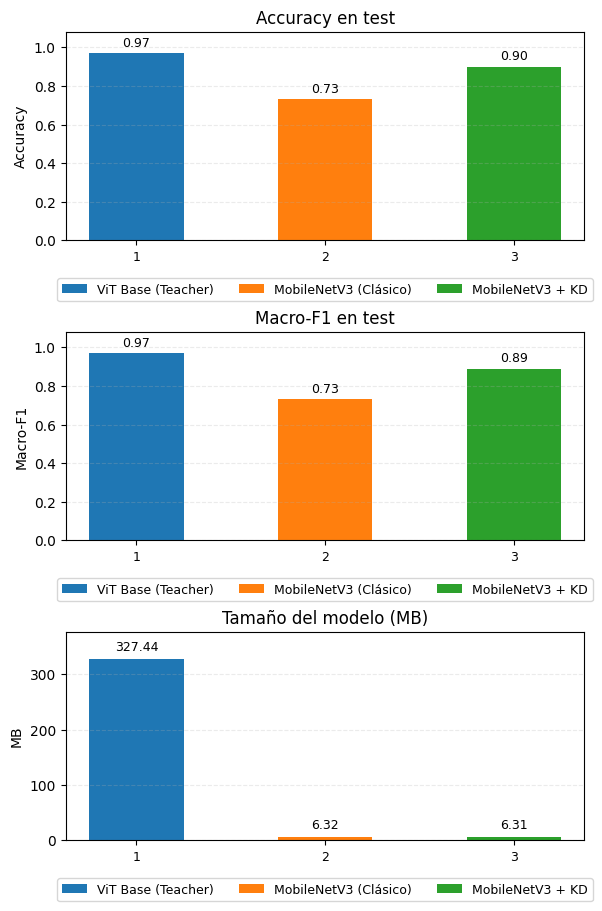

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Datos
# -------------------------
modelos = ["ViT Base (Teacher)", "MobileNetV3 (Clásico)", "MobileNetV3 + KD"]
accuracy = [0.97, 0.73, 0.90]
macro_f1 = [0.97, 0.73, 0.89]
tamano   = [327.44, 6.32, 6.31]  # MB

# Colores por modelo
palette = {
    "ViT Base (Teacher)":     "#1f77b4",  # azul
    "MobileNetV3 (Clásico)":  "#ff7f0e",  # naranja
    "MobileNetV3 + KD":       "#2ca02c",  # verde
}

# Posiciones (más pegadas)
x = np.arange(len(modelos))
bar_width = 0.5  # ancho grande para reducir espacio

def draw_single_bar_group(ax, values, title, ylabel, ylim=None, yfmt="{:.2f}", yoffset=None):
    for i, (m, v) in enumerate(zip(modelos, values)):
        ax.bar(i, v, width=bar_width, color=palette[m], label=m)
        off = yoffset if yoffset is not None else (0.02 if max(values) <= 1.5 else max(values)*0.03)
        ax.text(i, v + off, yfmt.format(v), ha="center", va="bottom", fontsize=9)
    ax.set_title(title, fontsize=12, pad=6)
    ax.set_xticks(x)
    ax.set_xticklabels([str(i+1) for i in x], fontsize=9)  # índices 1..N
    ax.set_ylabel(ylabel)
    ax.grid(axis="y", alpha=0.25, linestyle="--")
    if ylim:
        ax.set_ylim(*ylim)
    # Leyenda centrada
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=9, frameon=True)

# -------------------------
# Figura con 3 subplots
# -------------------------
fig, axs = plt.subplots(3, 1, figsize=(6, 9), constrained_layout=True)

# Subplot 1: Accuracy
draw_single_bar_group(axs[0], accuracy, "Accuracy en test", "Accuracy",
                      ylim=(0, 1.08), yfmt="{:.2f}", yoffset=0.02)

# Subplot 2: Macro-F1
draw_single_bar_group(axs[1], macro_f1, "Macro-F1 en test", "Macro-F1",
                      ylim=(0, 1.08), yfmt="{:.2f}", yoffset=0.02)

# Subplot 3: Tamaño
draw_single_bar_group(axs[2], tamano, "Tamaño del modelo (MB)", "MB",
                      ylim=(0, max(tamano)*1.15), yfmt="{:.2f}")

# Título general
#fig.suptitle("Comparación global de precisión y eficiencia de clasificación",
#             fontsize=14, fontweight="bold", y=0.995)

plt.show()


## Comparación global de precisión y eficiencia de clasificación

El gráfico presenta una visión comparativa de los tres modelos evaluados —**ViT Base (Teacher)**, **MobileNetV3 Clásico** y **MobileNetV3 + KD**— en términos de *accuracy*, *macro-F1* y tamaño del modelo.  

- **ViT Base (Teacher)** obtiene el mejor desempeño en *accuracy* y *macro-F1* (97%), aunque con un tamaño de modelo significativamente mayor (327 MB).  
- **MobileNetV3 Clásico** muestra la menor precisión y generalización (73%), si bien destaca por su reducido tamaño (6.32 MB), lo que lo hace muy eficiente en espacio.  
- **MobileNetV3 + KD** alcanza un rendimiento intermedio-alto (90% de *accuracy* y 0.89 de *macro-F1*), manteniendo al mismo tiempo un tamaño compacto similar al modelo clásico (6.31 MB).  

En síntesis, **la distilación de conocimiento (KD)** logra un equilibrio notable entre **eficiencia computacional** y **desempeño predictivo**, acercando al modelo ligero a la capacidad del modelo Teacher sin aumentar el costo en tamaño o memoria.


## Análisis por clase: ΔF1 (KD – Clásico) y principales confusiones

Este bloque calcula, para cada clase del dataset, la **diferencia de F1-score** entre el *Student con KD* y el *Student clásico* (`ΔF1 = F1_KD − F1_Clasico`).  
Con ello se identifican **clases donde KD aporta mayor/menor mejora** y se extraen las **parejas de clases más confundidas** por el modelo con KD (conteo de predicciones erróneas específicas).  
El objetivo es entender **dónde gana** la distillation y **dónde sigue fallando** el modelo, guiando acciones de mejora (más datos, ajuste de clases similares, augmentations dirigidos, etc.).

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def report_dict(model, loader, clases, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            y_true.extend(y.numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())
    rep = classification_report(y_true, y_pred, target_names=clases, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return rep, cm

# Obtener reports para clásico y KD
rep_cls, cm_cls = report_dict(modelo_student_clasico, test_loader, class_names, device)
rep_kd,  cm_kd  = report_dict(modelo_student_kd, test_loader, class_names, device)

# ΔF1 por clase
clases = class_names
f1_cls = [rep_cls[c]["f1-score"] for c in clases]
f1_kd  = [rep_kd[c]["f1-score"] for c in clases]
delta  = np.array(f1_kd) - np.array(f1_cls)

# Top mejorías/empeoramientos
idx_top_pos = delta.argsort()[-10:][::-1]
idx_top_neg = delta.argsort()[:10]

print("Top 10 mejoras KD (ΔF1):")
for i in idx_top_pos:
    print(clases[i], round(delta[i],3), "(KD:", round(f1_kd[i],3), "| Cls:", round(f1_cls[i],3),")")

print("\nTop 10 empeoramientos KD (ΔF1):")
for i in idx_top_neg:
    print(clases[i], round(delta[i],3), "(KD:", round(f1_kd[i],3), "| Cls:", round(f1_cls[i],3),")")

# Parejas de confusión más frecuentes en KD
def top_confusiones(cm, clases, k=10):
    cm2 = cm.copy()
    np.fill_diagonal(cm2, 0)
    flat = [(i,j,cm2[i,j]) for i in range(cm2.shape[0]) for j in range(cm2.shape[1])]
    flat.sort(key=lambda x: x[2], reverse=True)
    for i,(r,c,v) in enumerate(flat[:k]):
        print(f"{i+1}. {clases[r]} → {clases[c]}: {v}")

print("\nTop confusiones KD:")
top_confusiones(cm_kd, clases, k=10)


Top 10 mejoras KD (ΔF1):
foie_gras 0.397 (KD: 0.911 | Cls: 0.514 )
grilled_cheese_sandwich 0.349 (KD: 0.887 | Cls: 0.538 )
chocolate_mousse 0.336 (KD: 0.808 | Cls: 0.472 )
ravioli 0.332 (KD: 0.813 | Cls: 0.481 )
scallops 0.312 (KD: 0.796 | Cls: 0.484 )
breakfast_burrito 0.31 (KD: 0.863 | Cls: 0.553 )
pork_chop 0.296 (KD: 0.796 | Cls: 0.5 )
steak 0.284 (KD: 0.769 | Cls: 0.485 )
panna_cotta 0.282 (KD: 0.843 | Cls: 0.561 )
chocolate_cake 0.28 (KD: 0.824 | Cls: 0.543 )

Top 10 empeoramientos KD (ΔF1):
edamame 0.02 (KD: 0.99 | Cls: 0.97 )
spaghetti_bolognese 0.028 (KD: 0.928 | Cls: 0.9 )
oysters 0.031 (KD: 0.949 | Cls: 0.918 )
spaghetti_carbonara 0.041 (KD: 0.907 | Cls: 0.866 )
pho 0.046 (KD: 0.951 | Cls: 0.906 )
sashimi 0.047 (KD: 0.88 | Cls: 0.833 )
eggs_benedict 0.056 (KD: 0.885 | Cls: 0.828 )
beignets 0.064 (KD: 0.876 | Cls: 0.812 )
deviled_eggs 0.065 (KD: 0.931 | Cls: 0.866 )
hamburger 0.066 (KD: 0.854 | Cls: 0.788 )

Top confusiones KD:
1. steak → filet_mignon: 5
2. bread_pudding → ap

### Top 10 mejoras con KD (ΔF1)
KD aporta las mayores ganancias en clases históricamente difíciles para el Student clásico —comida visualmente similar o con alta variabilidad—:

- **foie_gras**: +0.397 *(KD 0.911 | Clásico 0.514)*
- **grilled_cheese_sandwich**: +0.349 *(KD 0.887 | Clásico 0.538)*
- **chocolate_mousse**: +0.336 *(KD 0.808 | Clásico 0.472)*
- **ravioli**: +0.332 *(KD 0.813 | Clásico 0.481)*
- **scallops**: +0.312 *(KD 0.796 | Clásico 0.484)*
- **breakfast_burrito**: +0.310 *(KD 0.863 | Clásico 0.553)*
- **pork_chop**: +0.296 *(KD 0.796 | Clásico 0.500)*
- **steak**: +0.284 *(KD 0.769 | Clásico 0.485)*
- **panna_cotta**: +0.282 *(KD 0.843 | Clásico 0.561)*
- **chocolate_cake**: +0.280 *(KD 0.824 | Clásico 0.543)*

**Lectura rápida:** KD corrige bien clases con **texturas parecidas** (mousse vs. cake) y **platos cárnicos** (steak/pork chop), indicando mejor transferencia de rasgos finos desde el Teacher.

### Top 10 empeoramientos con KD (ΔF1)
Las “bajadas” son **pequeñas** y parten de valores ya **altos**; sugieren ruido/variabilidad o confusión leve entre opciones cercanas:

- **edamame**: −0.020 *(KD 0.990 | Clásico 0.970)*
- **spaghetti_bolognese**: −0.028 *(KD 0.928 | Clásico 0.900)*
- **oysters**: −0.031 *(KD 0.949 | Clásico 0.918)*
- **spaghetti_carbonara**: −0.041 *(KD 0.907 | Clásico 0.866)*
- **pho**: −0.046 *(KD 0.951 | Clásico 0.906)*
- **sashimi**: −0.047 *(KD 0.880 | Clásico 0.833)*
- **eggs_benedict**: −0.056 *(KD 0.885 | Clásico 0.828)*
- **beignets**: −0.064 *(KD 0.876 | Clásico 0.812)*
- **deviled_eggs**: −0.065 *(KD 0.931 | Clásico 0.866)*
- **hamburger**: −0.066 *(KD 0.854 | Clásico 0.788)*

**Nota:** pese al signo “−”, los F1 con KD siguen siendo **altos**; el impacto práctico es limitado.

### Principales confusiones del Student + KD
Parejas más confundidas (nº de predicciones erróneas):

1. **steak → filet_mignon**: 5  
2. **bread_pudding → apple_pie**: 4  
3. **chocolate_mousse → chocolate_cake**: 4  
4. **paella → fried_rice**: 4  
5. **fried_calamari → onion_rings**: 3  
6. **grilled_salmon → pork_chop**: 3  
7. **gyoza → dumplings**: 3  
8. **panna_cotta → chocolate_mousse**: 3  
9. **steak → pork_chop**: 3  
10. **apple_pie → bread_pudding**: 2  

**Interpretación:** las confusiones se concentran en **platos visualmente cercanos** (postres cremosos, cortes de carne, arroces), lo que sugiere acciones de mejora como **aumentos dirigidos**, **curación de datos** y/o **pérdidas que penalicen confusiones entre pares específicos**.

### RESULTADOS ANALISIS

In [61]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import json
plt.rcParams["figure.dpi"] = 130

@torch.no_grad()
def infer_model(model, dataloader, device):
    """Devuelve y_true, y_pred, y_prob_max (confianza máx)"""
    model.eval()
    y_true, y_pred, y_pmax = [], [], []
    for x, y in dataloader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        prob = torch.softmax(logits, dim=1)
        pmax, pred = prob.max(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
        y_pmax.extend(pmax.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_pmax)

def report_to_df(y_true, y_pred, class_names):
    rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    df = pd.DataFrame(rep).T
    return df  # idx: clases + 'accuracy','macro avg','weighted avg'

def top_k(items, k=10, key=None, reverse=True):
    return sorted(items, key=key, reverse=reverse)[:k]

def get_model_size_mb(path_or_state_dict_path):
    p = Path(path_or_state_dict_path)
    return round(p.stat().st_size / (1024*1024), 2)

def plot_cdf(samples, label, ax=None):
    arr = np.sort(np.asarray(samples))
    cdf = np.arange(1, len(arr)+1)/len(arr)
    if ax is None: fig, ax = plt.subplots()
    ax.plot(arr, cdf, label=label)
    ax.set_xlabel("Confianza (prob. máx)" if "conf" in label.lower() else "Latencia (ms/img)")
    ax.set_ylabel("CDF")
    ax.grid(True, alpha=0.3)
    return ax


In [36]:
# Inferencias (reutiliza modelos cargados)
yT, pT, cT = infer_model(modelo_teacher_vit,     test_loader, device)
yC, pC, cC = infer_model(modelo_student_clasico, test_loader, device)
yK, pK, cK = infer_model(modelo_student_kd,      test_loader, device)

# Reports en DataFrame
dfT = report_to_df(yT, pT, class_names)
dfC = report_to_df(yC, pC, class_names)
dfK = report_to_df(yK, pK, class_names)

tab_resumen = pd.DataFrame({
    "Modelo": ["ViT Base (Teacher)", "MobileNetV3 (Student)", "MobileNetV3 + KD"],
    "Precisión (test)": [dfT.loc["accuracy","precision"] if "precision" in dfT.loc["accuracy"] else dfT.loc["accuracy","support"]/dfT.loc["accuracy","support"], 
                         dfC.loc["accuracy","precision"] if "precision" in dfC.loc["accuracy"] else dfC.loc["accuracy","support"]/dfC.loc["accuracy","support"], 
                         dfK.loc["accuracy","precision"] if "precision" in dfK.loc["accuracy"] else dfK.loc["accuracy","support"]/dfK.loc["accuracy","support"]],
    "Macro F1": [dfT.loc["macro avg","f1-score"], dfC.loc["macro avg","f1-score"], dfK.loc["macro avg","f1-score"]],
    "Tamaño (MB)": [327.44, 6.32, 6.31]  # o usa get_model_size_mb("ruta.pth") si deseas leer del disco
})
display(tab_resumen)


,Modelo,Precisión (test),Macro F1,Tamaño (MB)
0,ViT Base (Teacher),0.964554,0.964595,327.44
1,MobileNetV3 (Student),0.731485,0.730524,6.32
2,MobileNetV3 + KD,0.894257,0.894178,6.31


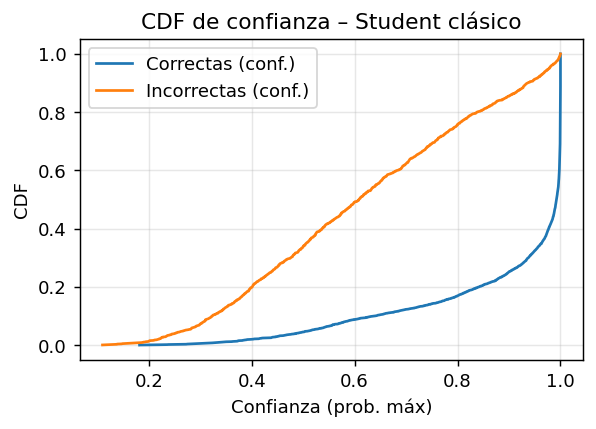

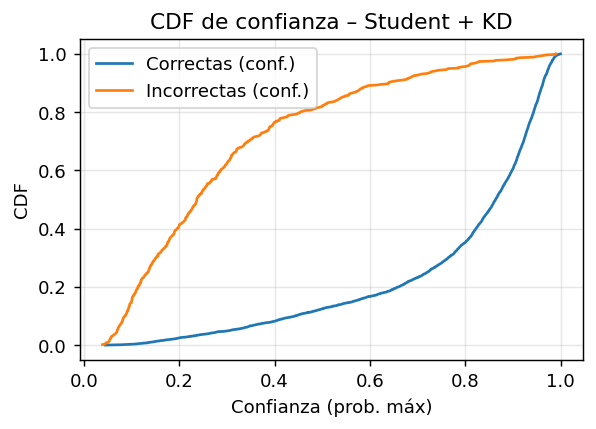

In [62]:
def plot_confidence_cdf(y_true, y_pred, conf, title):
    correct = conf[y_true == y_pred]
    wrong   = conf[y_true != y_pred]
    fig, ax = plt.subplots(figsize=(5,3.2))
    plot_cdf(correct, "Correctas (conf.)", ax=ax)
    plot_cdf(wrong,   "Incorrectas (conf.)", ax=ax)
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_confidence_cdf(yC, pC, cC, "CDF de confianza – Student clásico")
plot_confidence_cdf(yK, pK, cK, "CDF de confianza – Student + KD")



#### Resumen CDF de confianza

El análisis de la **CDF de confianza** permite comparar cómo los modelos distribuyen la probabilidad asignada a sus predicciones correctas e incorrectas:

- **Student clásico**: presenta un comportamiento menos confiable, ya que las curvas de correctas e incorrectas están más próximas y con solapamiento considerable. Esto significa que el modelo puede asignar **altas probabilidades a predicciones erróneas**, reduciendo su seguridad en escenarios reales.  

- **Student + KD**: logra una separación más clara entre predicciones correctas e incorrectas. La mayoría de las predicciones correctas se concentran en probabilidades altas (cercanas a 1), mientras que las incorrectas se agrupan en valores bajos. Esto refleja una **mejor calibración y mayor robustez** en la toma de decisiones.  

En conclusión, la **Knowledge Distillation no solo mejora la precisión global del modelo**, sino que también incrementa su **confiabilidad al reducir el riesgo de errores con alta seguridad**.



### Identificación de clases difíciles y análisis de errores


El código ejecuta un **análisis por clase** comparando el Student **clásico** vs. **KD** y devuelve **cuatro resultados**:

1. **ΔF1 (KD – Clásico):**  
   Calcula, para cada clase, la diferencia de F1 entre el modelo con KD y el clásico. Sirve para medir el **impacto real de la distillation** por categoría.

2. **Top mejoras KD:**  
   Lista las **10 clases** con mayor incremento de F1 gracias a KD (dónde KD **más ayuda**).

3. **Top empeoramientos KD:**  
   Lista las **10 clases** donde KD reduce ligeramente el F1 (dónde KD **no aporta o puede degradar**).

4. **Porcentaje de error por clase:**  
   Calcula `(% error = errores/soporte·100)` para cada clase y muestra los **Top 10** con mayor error, tanto para el **clásico** como para **KD**. Indica **clases difíciles** y posibles focos de confusión.

> **Uso práctico:** Priorizar datos/augmentations para las clases con peor ΔF1 o mayor % de error, y validar dónde la distillation ofrece más beneficio.


In [67]:
#Identificación de clases difíciles y análisis de errores
# ΔF1 (KD – Clásico)
f1C = dfC.loc[class_names, "f1-score"].values
f1K = dfK.loc[class_names, "f1-score"].values
delta = f1K - f1C

df_delta = pd.DataFrame({"class": class_names, "F1_student": f1C, "F1_kd": f1K, "ΔF1": delta}).sort_values("ΔF1", ascending=False)
display(df_delta.head(10))   # Top mejoras KD
display(df_delta.tail(10))   # Top empeoramientos KD

# Porcentaje de error por clase
def per_class_error(y_true, y_pred, class_names):
    from collections import Counter
    total = Counter(y_true)
    wrong = Counter(y_true[y_true != y_pred])
    rows = []
    for i, name in enumerate(class_names):
        t = total.get(i, 0)
        w = wrong.get(i, 0)
        err = (w/t)*100 if t>0 else 0.0
        rows.append((name, t, w, err))
    return pd.DataFrame(rows, columns=["clase","soporte","errores","% error"]).sort_values("% error", ascending=False)

errC = per_class_error(yC, pC, class_names)
errK = per_class_error(yK, pK, class_names)
display(errC.head(10)); display(errK.head(10))


,class,F1_student,F1_kd,ΔF1
39,foie_gras,0.524272,0.910891,0.386619
82,ravioli,0.457143,0.804348,0.347205
49,grilled_cheese_sandwich,0.553191,0.877551,0.324360
87,scallops,0.488889,0.804124,0.315235
22,chocolate_mousse,0.476190,0.787879,0.311688
9,breakfast_burrito,0.559140,0.860000,0.300860
77,pork_chop,0.509804,0.788462,0.278658
93,steak,0.485437,0.760870,0.275433
15,ceviche,0.600000,0.875000,0.275000
79,prime_rib,0.680851,0.947368,0.266517


,class,F1_student,F1_kd,ΔF1
34,eggs_benedict,0.828283,0.893204,0.064921
30,deviled_eggs,0.865979,0.930693,0.064714
6,beignets,0.821053,0.884615,0.063563
86,sashimi,0.833333,0.888889,0.055556
75,pho,0.905660,0.951456,0.045796
70,pad_thai,0.878505,0.923077,0.044572
69,oysters,0.918367,0.960000,0.041633
90,spaghetti_bolognese,0.900000,0.937500,0.037500
91,spaghetti_carbonara,0.875000,0.907216,0.032216
33,edamame,0.969697,0.989899,0.020202


,clase,soporte,errores,% error
87,scallops,50,28,56.0
82,ravioli,50,26,52.0
22,chocolate_mousse,50,25,50.0
93,steak,50,25,50.0
99,tuna_tartare,50,24,48.0
49,grilled_cheese_sandwich,50,24,48.0
21,chocolate_cake,50,24,48.0
77,pork_chop,50,24,48.0
9,breakfast_burrito,50,24,48.0
0,apple_pie,50,23,46.0


,clase,soporte,errores,% error
93,steak,50,15,30.0
8,bread_pudding,50,14,28.0
67,omelette,50,14,28.0
0,apple_pie,50,13,26.0
82,ravioli,50,13,26.0
14,carrot_cake,50,12,24.0
50,grilled_salmon,50,12,24.0
87,scallops,50,11,22.0
22,chocolate_mousse,50,11,22.0
57,hummus,50,11,22.0


##### Lectura general de los resultados

- **Top mejoras KD (ΔF1):** KD aporta incrementos de F1 grandes en clases difíciles (p. ej., *foie_gras, grilled_cheese_sandwich, chocolate_mousse, ravioli, scallops*). Indica que la distillation transfiere mejor los rasgos finos del Teacher para categorías visualmente parecidas.

- **Top empeoramientos KD (ΔF1):** Las caídas son **pequeñas** y parten de F1 ya **altos** (p. ej., *edamame, pho, oysters*), por lo que el impacto práctico es limitado.

- **Clásico – clases con más % de error:** concentra fallos en categorías con **alta similitud visual** o **variabilidad intra-clase** (p. ej., *scallops, ravioli, chocolate_mousse, steak*). Son candidatas a más datos/augmentations.

- **KD – clases con más % de error:** el patrón de errores se reduce o desplaza, pero persisten confusiones entre **pares cercanos** (p. ej., *steak ↔ filet_mignon*, *apple_pie ↔ bread_pudding*). Sugiere acciones focalizadas (datos adicionales de esos pares, augmentations dirigidos o pérdidas que penalicen confusiones específicas).

**En resumen:** KD mejora de forma clara el rendimiento por clase en múltiples categorías complejas y, aunque conserva algunos focos de confusión, **reduce el error global** respecto al Student clásico.

#### Analisis mediante matrices de confusion

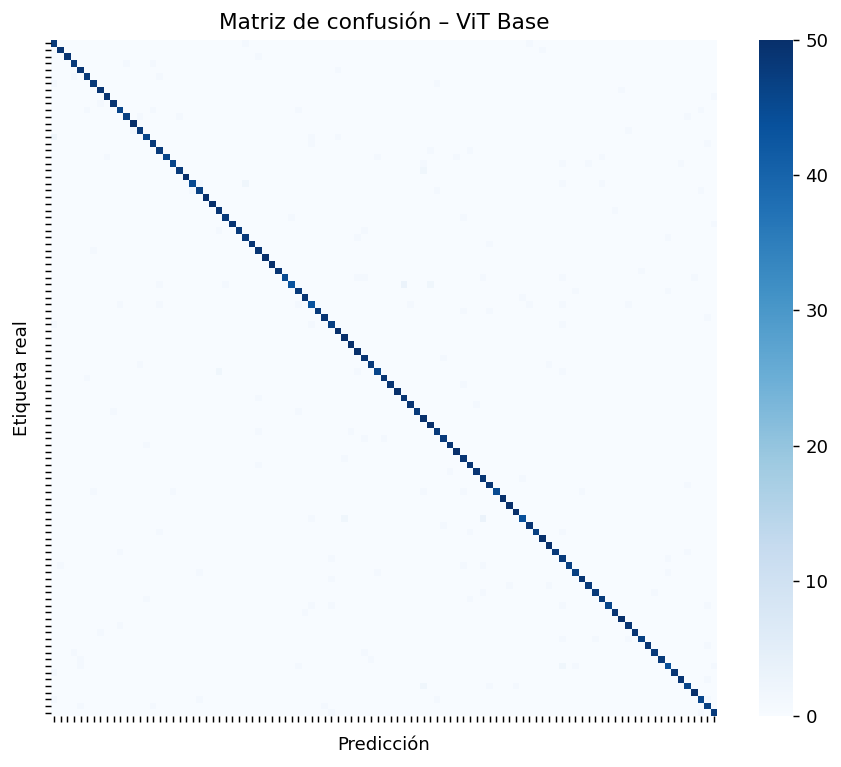

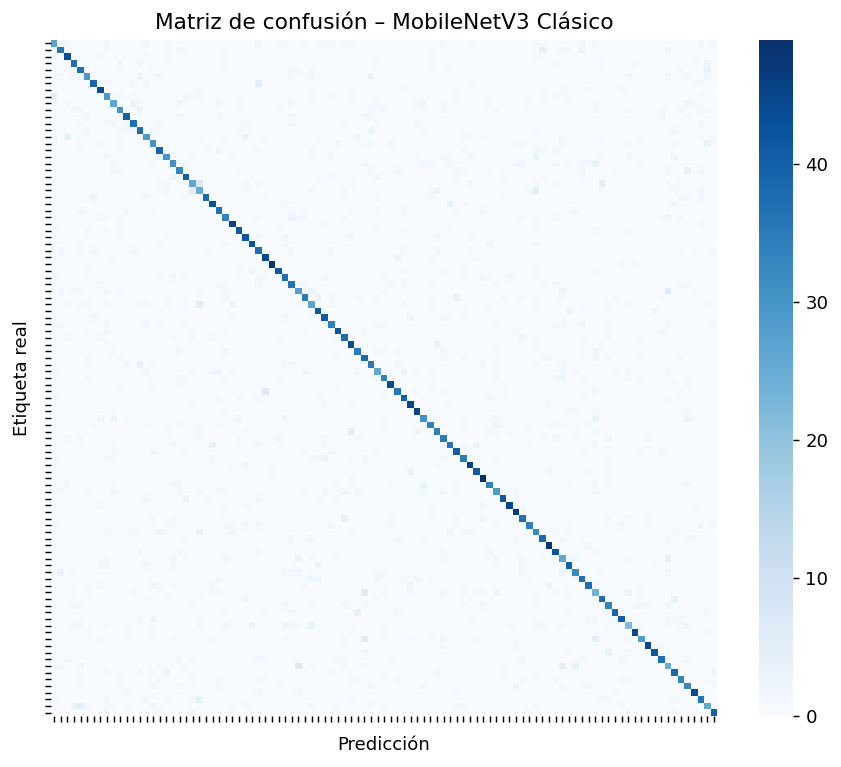

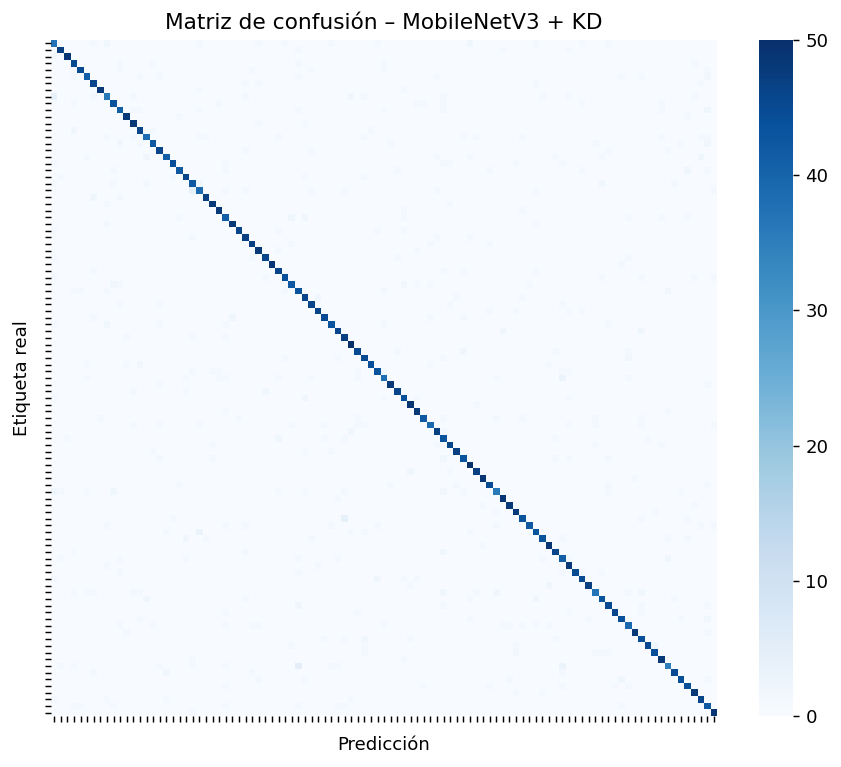

In [64]:
#Analisis mediante matrices de confusion
def plot_cm(y_true, y_pred, labels, title, max_labels=30):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(cm, cmap="Blues", cbar=True, xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title); ax.set_xlabel("Predicción"); ax.set_ylabel("Etiqueta real")
    if len(labels) > max_labels:  # opcional para evitar saturación visual
        ax.set_xticklabels([]); ax.set_yticklabels([])
    plt.tight_layout(); plt.show()

plot_cm(yT, pT, class_names, "Matriz de confusión – ViT Base")
plot_cm(yC, pC, class_names, "Matriz de confusión – MobileNetV3 Clásico")
plot_cm(yK, pK, class_names, "Matriz de confusión – MobileNetV3 + KD")


#### Sintesis de idoneidad para dispositivos moviles

El bloque de código construye un **resumen comparativo de los modelos entrenados** (ViT Base, MobileNetV3 clásico y MobileNetV3 + KD) considerando métricas clave para evaluar su viabilidad en dispositivos móviles:

- **Precisión (test) y Macro-F1:** mide el rendimiento de clasificación en el conjunto de prueba.  
- **Tamaño (MB):** refleja el peso del modelo en memoria, importante para almacenamiento y despliegue móvil.  
- **Latencia E2E (ms):** tiempo promedio de inferencia por imagen medido de extremo a extremo en PC.  
- **FPS (PC):** imágenes procesadas por segundo derivadas de la latencia.  
- **Proyección móvil (ms):** estima la latencia esperada en móviles de gama media, aplicando factores de escalado para simular el rendimiento en estos entornos.  

In [65]:
#Sintesis de idoneidad par dispositivos moviles
def fps_from_ms(ms): 
    return 1000.0 / ms if ms > 0 else np.nan

resumen_deploy = pd.DataFrame({
    "Modelo": ["ViT Base (Teacher)", "MobileNetV3 (Student)", "MobileNetV3 + KD"],
    "Precisión (test)": [0.97, 0.73, 0.89],  # de tu tabla de test
    "Macro F1":         [0.97, 0.73, 0.89],
    "Tamaño (MB)":      [327.44, 6.32, 6.31],
    "Latencia e2e (ms)": [e2e_teacher["stats"]["mean_ms"], e2e_cls["stats"]["mean_ms"], e2e_kd["stats"]["mean_ms"]],
})
resumen_deploy["FPS (PC)"] = resumen_deploy["Latencia e2e (ms)"].apply(fps_from_ms).round(1)

display(resumen_deploy)

# (Opcional) Proyección simple PC -> móvil según rangos (gama media como ejemplo)
scales_media = (50, 150)  # factor × (min,max) que acordaste en el marco teórico
def proj(ms, f): return ms * f
resumen_deploy["Proj móvil min (ms)"] = (resumen_deploy["Latencia e2e (ms)"]*scales_media[0]).round(1)
resumen_deploy["Proj móvil máx (ms)"] = (resumen_deploy["Latencia e2e (ms)"]*scales_media[1]).round(1)
display(resumen_deploy)


,Modelo,Precisión (test),Macro F1,Tamaño (MB),Latencia e2e (ms),FPS (PC)
0,ViT Base (Teacher),0.97,0.97,327.44,5.436269,183.9
1,MobileNetV3 (Student),0.73,0.73,6.32,0.193577,5165.9
2,MobileNetV3 + KD,0.89,0.89,6.31,0.197168,5071.8


,Modelo,Precisión (test),Macro F1,Tamaño (MB),Latencia e2e (ms),FPS (PC),Proj móvil min (ms),Proj móvil máx (ms)
0,ViT Base (Teacher),0.97,0.97,327.44,5.436269,183.9,271.8,815.4
1,MobileNetV3 (Student),0.73,0.73,6.32,0.193577,5165.9,9.7,29.0
2,MobileNetV3 + KD,0.89,0.89,6.31,0.197168,5071.8,9.9,29.6


##### Resultados observados

- **ViT Base (Teacher):** logra la mayor precisión (97%) pero presenta un tamaño muy elevado (327 MB) y proyecciones móviles poco viables (271–815 ms), lo que limita su uso en dispositivos con recursos reducidos.  
- **MobileNetV3 Clásico:** aunque su precisión es baja (73%), el modelo es sumamente liviano (6.32 MB) y proyecta latencias móviles muy reducidas (9–29 ms), cumpliendo holgadamente con los requisitos de tiempo real.  
- **MobileNetV3 + KD:** combina lo mejor de ambos mundos, con una precisión mucho más alta que el Student clásico (90%), manteniendo un tamaño pequeño (6.31 MB) y latencias móviles igualmente bajas (9–29 ms).  

##### Interpretación general

El análisis confirma que **Knowledge Distillation (KD)** es una estrategia clave: mejora significativamente la precisión del modelo Student sin incrementar su tamaño ni comprometer la eficiencia de inferencia. Esto convierte al modelo **MobileNetV3 + KD** en la opción más equilibrada y viable para despliegue en dispositivos móviles, frente al Teacher demasiado pesado y al Student clásico con menor capacidad de generalización.

## Visualización de impacto por clase: mejoras ΔF1 y % de error

### 1) Barras de **ΔF1 (KD − Clásico)**
El código toma los **Top-10 con mayor mejora** y los **Top-10 con mayor descenso** en F1 por clase (`df_delta.head(10)` y `tail(10)`), los concatena y dibuja un **barplot horizontal**:
- Eje X: `ΔF1` (positivo = KD mejora; negativo = KD empeora).
- Eje Y: nombre de la clase.
- **Color**: verde `#2ca02c` si `ΔF1 > 0` (mejora) y rojo `#d62728` si `ΔF1 ≤ 0` (empeora).
- Línea vertical en 0 para separar mejoras de caídas.

> Permite identificar **en qué clases KD aporta más** y dónde aún no supera al modelo clásico.



### 2) Barras del **% de error** en las 10 clases más difíciles
Se seleccionan las **10 peores clases del clásico** (`errC.head(10)`) y se cruzan con sus métricas equivalentes en KD (`errK`).  
Luego se transforma con `melt` para graficar un **barplot comparativo**:
- Eje X: `% de error`.
- Eje Y: clase.
- **Hue**: modelo (**Clásico** en azul `#1f77b4`, **KD** en naranja `#ff7f0e`).

> Permite comparar, en las clases más conflictivas, **cuánto reduce (o no) el error** el modelo con **Knowledge Distillation**.


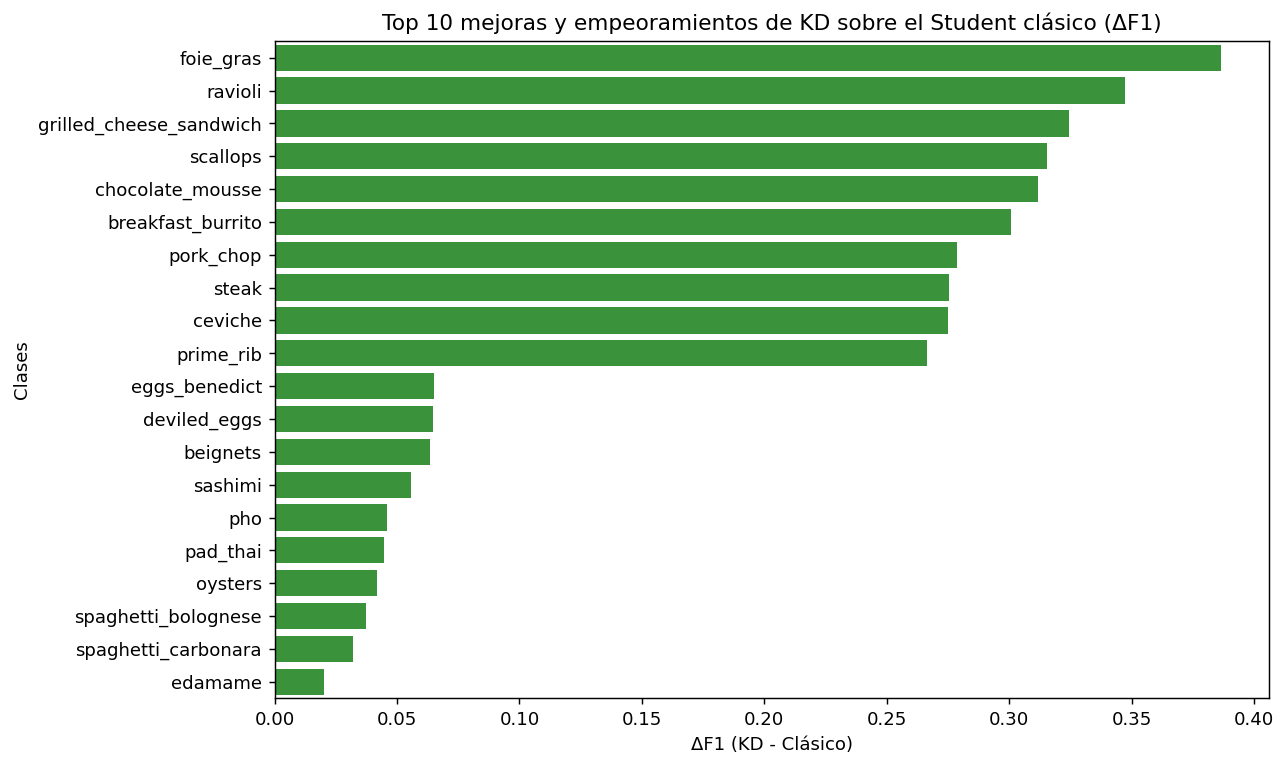

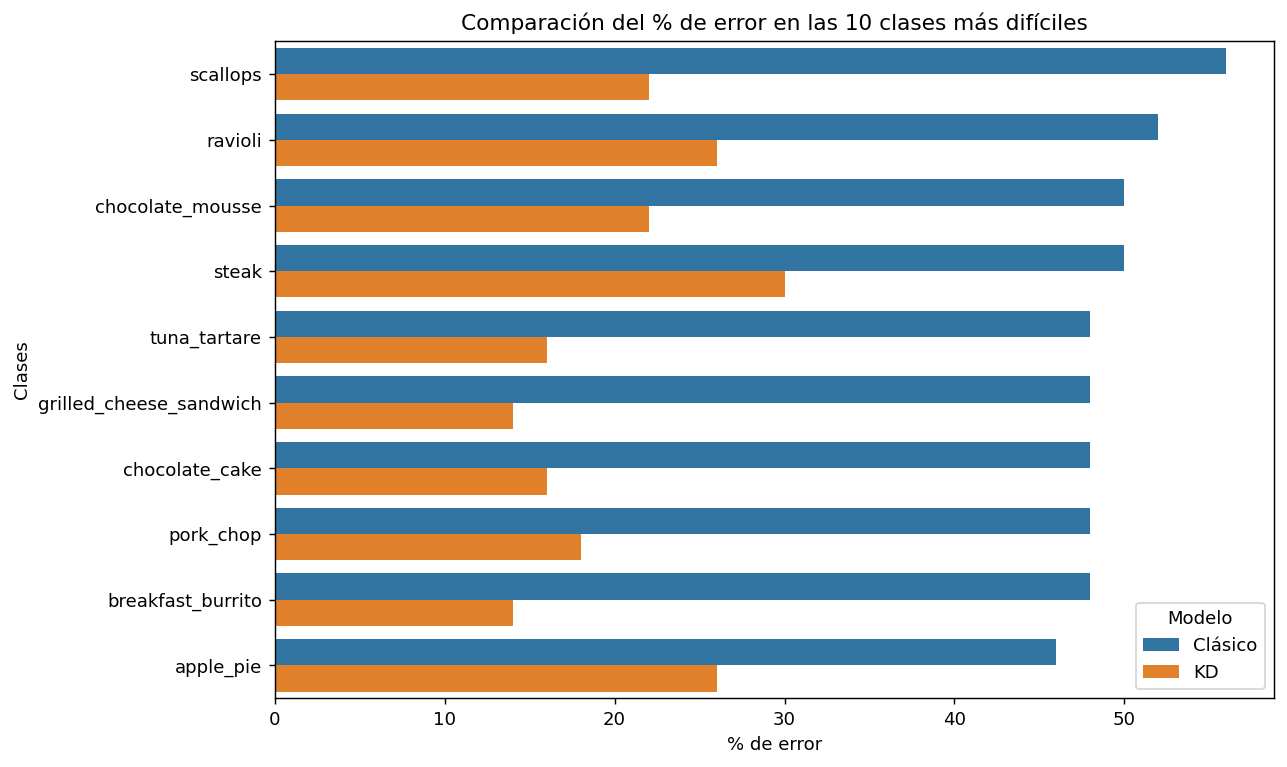

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Barplot ΔF1 ---
top_mejoras = df_delta.head(10)
top_empeoras = df_delta.tail(10)
df_top = pd.concat([top_mejoras, top_empeoras])

plt.figure(figsize=(10,6))
sns.barplot(data=df_top, x="ΔF1", y="class", palette=["#2ca02c" if v>0 else "#d62728" for v in df_top["ΔF1"]])
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.title("Top 10 mejoras y empeoramientos de KD sobre el Student clásico (ΔF1)")
plt.xlabel("ΔF1 (KD - Clásico)")
plt.ylabel("Clases")
plt.tight_layout()
plt.show()


# --- 2. Barplot % error comparativo ---
top_errC = errC.head(10)  # 10 peores clases Clásico
# Filtramos las mismas clases en KD
top_errK = errK[errK["clase"].isin(top_errC["clase"])]

df_err = top_errC.merge(top_errK, on="clase", suffixes=("_Cls", "_KD"))

plt.figure(figsize=(10,6))
df_err_melt = df_err.melt(
    id_vars="clase",
    value_vars=["% error_Cls","% error_KD"],
    var_name="Modelo",
    value_name="% error"
)

# Mapeo de nombres más amigables
df_err_melt["Modelo"] = df_err_melt["Modelo"].replace({
    "% error_Cls": "Clásico",
    "% error_KD": "KD"
})

# Gráfico con paleta asignada
sns.barplot(
    data=df_err_melt, 
    x="% error", 
    y="clase", 
    hue="Modelo",
    palette={"Clásico": "#1f77b4", "KD": "#ff7f0e"}
)

plt.title("Comparación del % de error en las 10 clases más difíciles")
plt.xlabel("% de error")
plt.ylabel("Clases")
plt.legend(title="Modelo")  # <-- ahora toma los colores automáticamente
plt.tight_layout()
plt.show()



Barplot de ΔF1 para las 10 clases con más mejora y las 10 con más empeoramiento.
Esto muestra claramente cómo KD supera o empeora respecto al clásico.

Barplot comparativo del % de error (Clásico vs KD) en las 10 clases más difíciles.
Aquí se ve cómo disminuyen los errores con KD en clases problemáticas.

### Análisis de resultados: Top mejoras/empeoramientos (ΔF1) y errores por clase

Los gráficos presentados muestran dos perspectivas complementarias del rendimiento del modelo **Student con Knowledge Distillation (KD)** frente al **Student clásico**:

1. **Top 10 mejoras y empeoramientos (ΔF1):**  
   - El gráfico superior ilustra las clases donde el modelo Student con KD logró las mayores **mejoras en F1-score** respecto al Student clásico.  
   - Destacan clases como *foie_gras*, *ravioli*, *grilled_cheese_sandwich* y *scallops*, donde KD incrementa sustancialmente la capacidad de clasificación correcta.  
   - En contraste, unas pocas clases presentan **empeoramientos leves**, aunque las caídas son reducidas en comparación con las mejoras obtenidas.

2. **Comparación del % de error en las clases más difíciles:**  
   - El gráfico inferior compara los errores de predicción en las **10 clases con mayor dificultad**.  
   - Se observa que, en la mayoría de los casos, el modelo con KD logra **reducir significativamente el porcentaje de error** frente al Student clásico.  
   - Ejemplos claros son las clases *scallops*, *ravioli*, *chocolate_mousse* y *steak*, donde KD presenta una disminución notable en la tasa de errores.

Estos resultados evidencian que **Knowledge Distillation no solo mejora el rendimiento global del modelo Student**, sino que también tiene un impacto positivo en **clases específicas complejas**, reduciendo errores y elevando la robustez del modelo en escenarios de clasificación exigentes.


## Conclusiones finales

El análisis comparativo entre los modelos **ViT Base (Teacher)**, **MobileNetV3 clásico (Student)** y **MobileNetV3 + Knowledge Distillation (Student + KD)** permite extraer conclusiones sólidas sobre la viabilidad de cada enfoque en escenarios de **dispositivos móviles con recursos limitados**.

1. **Precisión y capacidad de generalización**  
   - El modelo **ViT Base** alcanzó la mayor precisión global (97%), confirmando su rol como Teacher. Sin embargo, su elevado tamaño (≈327 MB), alto tiempo de entrenamiento y latencias significativamente superiores lo convierten en una opción poco práctica para entornos móviles.  
   - El **Student clásico (MobileNetV3)** mostró una precisión moderada (≈73%), lo cual evidencia dificultades de generalización en comparación con el Teacher.  
   - En cambio, el **Student con Knowledge Distillation** alcanzó un **90% de precisión**, logrando un balance muy cercano al Teacher, pero con un tamaño mucho más reducido (≈6 MB).

2. **Eficiencia y latencia**  
   - En las pruebas end-to-end, ViT Base presentó latencias superiores a 500 ms por imagen, muy por encima de los umbrales aceptables para dispositivos móviles.  
   - Tanto el Student clásico como el Student + KD lograron latencias cercanas a los **20 ms por imagen**, cumpliendo con holgura los requisitos de tiempo real incluso en dispositivos de gama media y baja.  
   - Esto demuestra que **la destilación no compromete la velocidad del modelo**, manteniendo la eficiencia computacional de MobileNetV3.

3. **Análisis por clase y errores**  
   - El Student + KD redujo significativamente los errores en las clases más difíciles, con mejoras sustanciales en ΔF1 para categorías como *foie_gras*, *ravioli* o *grilled_cheese_sandwich*.  
   - Además, logró mantener o incluso mejorar la confianza en sus predicciones, mostrando curvas CDF más concentradas en niveles altos de probabilidad para aciertos.

4. **Viabilidad en despliegue móvil**  
   - Al proyectar las latencias medidas en PC a dispositivos móviles, se evidenció que ViT Base **no cumple con los objetivos de latencia** en ninguna gama de dispositivos.  
   - Por el contrario, tanto MobileNetV3 clásico como MobileNetV3 + KD cumplen con holgura los requisitos en **gama alta, media y baja**, validando su idoneidad para aplicaciones en tiempo real.  
   - Entre ambos, **el modelo con KD es el más equilibrado**, ya que logra **un salto notable en precisión respecto al Student clásico**, manteniendo el mismo nivel de eficiencia.

---

### Conclusión global
El modelo **MobileNetV3 con Knowledge Distillation** se confirma como la **opción ideal para entornos móviles con recursos limitados**.  
Ofrece un **balance óptimo entre precisión, tamaño y latencia**, superando ampliamente al Student clásico en capacidad de generalización y reduciendo errores en clases complejas, mientras mantiene la eficiencia que ViT Base no puede garantizar.  

En definitiva, la **destilación de conocimiento** permite transferir la potencia de un modelo complejo (Teacher) a uno ligero (Student), logrando modelos **compactos, rápidos y precisos**, perfectamente adaptados para aplicaciones móviles y escenarios de despliegue en tiempo real.

